In [1]:
import os
import glob
import pandas as pd
import numpy as np
import requests
import urllib
import unicodedata
from statistics import mean,pstdev
from datetime import datetime,timedelta
#import jpholiday
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose,STL
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import acf,pacf,adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from itertools import product
from typing import Union
import japanize_matplotlib
import seaborn
#import sweetviz as sv
import lightgbm as lgb
import catboost 
from catboost import cv,CatBoostClassifier,CatBoostRegressor, Pool
import xgboost as xgb
#import category_encoders
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold,StratifiedGroupKFold,TimeSeriesSplit,cross_val_score,GroupKFold
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.preprocessing import PolynomialFeatures,LabelEncoder
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.inspection import PartialDependenceDisplay

from collections import Counter
from imblearn.over_sampling import SMOTE,SMOTENC

from scipy.optimize import minimize
#from prophet import Prophet
#from prophet.diagnostics import performance_metrics,cross_validation
#from prophet.plot import add_changepoints_to_plot
#from neuralprophet import NeuralProphet
import optuna
#from optuna.integration import OptunaSearchCV
import webbrowser
from geopy.geocoders import Nominatim,Photon
from geopy.extra.rate_limiter import RateLimiter
from geopy.distance import geodesic
from geolib import geohash
#from normalize_japanese_addresses import normalize
import folium
import geopandas
import tqdm
from tqdm import tqdm_notebook

import requests
import urllib.parse
import re
import json
import joblib
import gc

TARGET="target"

cols=['価格情報区分', '都道府県名', '市区町村名', '地区名', '住所不一致_Flag', '住所', '最寄駅：名称',
       '最寄駅：距離（分）', '徒歩時間_10分単位', '間取り',
       '面積（㎡）', '建築年', '建物の構造', '用途', '今後の利用目的', '都市計画', '建ぺい率（％）', '容積率（％）',
       '取引時点', '改装', '取引の事情等', '取引価格（総額）_log', '単位面積あたりの取引価格_log', '建築西暦年',
       '築年数', 'log_面積（㎡）', '購入までの築年数', 
       '旧耐震フラグ', '最寄駅までの距離','target', 'pred_tg_lgbm', 'pred_lgbm', 'pred_cat', 'pred_weight',
       'target_price', 'mae']

def check_dataframe_elements(df):
    df.info()
    print("マルチインデックス=>",isinstance(df.index,pd.MultiIndex))
    print(df.shape)
    print("-----カラム名一覧-----")
    print(df.columns)
    for col in df.columns.to_list():
        print(f"-----{col}-----に含まれるユニークな値の数")
        print(df[col].nunique())
        print(f"-----{col}-----に含まれる値を被り無しで表示")
        print(df[col].unique())

In [2]:
oof_df=pd.read_csv("oof_full_df.csv")
oof_df=oof_df.set_index("ID")

oof_df=oof_df.drop(["target.1","target"],axis=1)
oof_df=oof_df.rename(columns={"target_tg":"target"})

In [3]:
check_dataframe_elements(oof_df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1009271 entries, 1046933 to 47011639
Data columns (total 66 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   価格情報区分                 1009271 non-null  object 
 1   都道府県名                  1009271 non-null  object 
 2   市区町村名                  1009271 non-null  object 
 3   地区名                    1009206 non-null  object 
 4   住所不一致_Flag             1009271 non-null  int64  
 5   住所                     1009271 non-null  object 
 6   最寄駅：名称                 1009220 non-null  object 
 7   最寄駅：距離（分）              964322 non-null   float64
 8   徒歩時間_10分単位             964322 non-null   float64
 9   x_api                  1009220 non-null  float64
 10  y_api                  1009220 non-null  float64
 11  lon                    998562 non-null   float64
 12  lat                    998562 non-null   float64
 13  間取り                    976570 non-null   object 
 14  面積（㎡）      

In [4]:
df_corr=oof_df.corr()
df_corr

C:\Users\yuto2\AppData\Local\Temp\ipykernel_20032\3034528542.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_corr=oof_df.corr()


,住所不一致_Flag,最寄駅：距離（分）,徒歩時間_10分単位,x_api,y_api,lon,lat,面積（㎡）,建ぺい率（％）,容積率（％）,...,県_市_geohash_5_駅徒歩時間平均,県_市_geohash_5_建築年平均,県_市_geohash_6_駅徒歩時間平均,県_市_geohash_6_建築年平均,県_市_geohash_7_駅徒歩時間平均,県_市_geohash_7_建築年平均,target,pred_tg_lgbm,pred_lgbm,pred_cat
住所不一致_Flag,1.000000,-0.020968,-0.020646,-0.054412,-0.022959,-0.056740,-0.026981,-0.036070,0.075703,0.103435,...,-0.035795,0.030827,-0.030071,0.026368,-0.024715,0.024106,0.003009,0.002027,0.002261,0.001796
最寄駅：距離（分）,-0.020968,1.000000,0.973613,-0.071305,-0.006174,-0.069233,-0.008046,0.132492,-0.299224,-0.319329,...,0.728681,-0.219983,0.878361,-0.224176,0.893865,-0.206636,-0.236624,-0.247294,-0.246614,-0.248750
徒歩時間_10分単位,-0.020646,0.973613,1.000000,-0.067691,-0.004305,-0.065343,-0.005670,0.129555,-0.277551,-0.295882,...,0.716177,-0.211819,0.859277,-0.215033,0.873276,-0.198091,-0.228272,-0.238602,-0.238022,-0.240246
x_api,-0.054412,-0.071305,-0.067691,1.000000,0.635566,0.911342,0.526771,-0.085865,-0.064108,0.005485,...,-0.099229,0.030662,-0.087130,0.020862,-0.085824,0.019230,0.189827,0.201804,0.201491,0.201022
y_api,-0.022959,-0.006174,-0.004305,0.635566,1.000000,0.577856,0.879648,0.027125,-0.004055,-0.021212,...,-0.010453,-0.101925,-0.013522,-0.069654,-0.013382,-0.062377,-0.041150,-0.041708,-0.041772,-0.042627
lon,-0.056740,-0.069233,-0.065343,0.911342,0.577856,1.000000,0.631101,-0.073952,-0.061591,0.002304,...,-0.088322,0.026719,-0.075314,0.013242,-0.073973,0.011222,0.171695,0.182516,0.182264,0.181765
lat,-0.026981,-0.008046,-0.005670,0.526771,0.879648,0.631101,1.000000,0.035015,-0.010693,-0.022868,...,-0.004198,-0.095857,-0.006257,-0.066384,-0.005776,-0.059246,-0.043037,-0.043885,-0.043858,-0.044788
面積（㎡）,-0.036070,0.132492,0.129555,-0.085865,0.027125,-0.073952,0.035015,1.000000,-0.255021,-0.281883,...,0.157451,-0.108689,0.152314,-0.028858,0.152411,-0.004248,0.373748,0.395783,0.403210,0.397515
建ぺい率（％）,0.075703,-0.299224,-0.277551,-0.064108,-0.004055,-0.061591,-0.010693,-0.255021,1.000000,0.767827,...,-0.222319,0.253265,-0.279820,0.221901,-0.289236,0.205642,0.033545,0.033994,0.034055,0.035279
容積率（％）,0.103435,-0.319329,-0.295882,0.005485,-0.021212,0.002304,-0.022868,-0.281883,0.767827,1.000000,...,-0.281150,0.356607,-0.311850,0.281281,-0.318959,0.257821,0.120951,0.126873,0.126415,0.127325


In [5]:
#print(abc)

In [6]:
def mae_loss_fn(true_targets,pred_weighted):
    return mean_absolute_error(true_targets,pred_weighted)

class WeightsSearcher:
    def __init__(self,loss_fn,bounds=[],mode="min",method="SLSQP"):
        self.loss_fn=loss_fn#損失関数
        self.bounds=bounds#重みの範囲
        self.mode=mode#最適化モード(minまたはmax)
        self.method=method#最適化方法(デフォルトは"SLSQP")

    # 目的関数のラッパー: 予測値、真のターゲット、目的関数を受け取り、重み付けされた予測値を計算する関数を返す
    def _objective_function_wrapper(self,pred_values,true_targets,obj_fn):
        def objective_function(weights):
            #print(pred_values)
            #予測値に重みを適用し、行ごとに合計
            pred_weighted=(pred_values*weights).sum(axis=1)
            #真のターゲットと重み付けされた予測値を使用してスコアを計算
            score = obj_fn(true_targets, pred_weighted)
            # 最適化モードに応じてスコアを反転
            return score if self.mode == "min" else score
        #目的関数を返す
        return objective_function

    #最適な重みを見つけるメソッド:検証予測値と真のターゲットを受け取り、最適化を実行
    def find_weights(self, val_preds, true_targets):
        len_models = len(self.bounds)#モデルの数を取得
        bounds = [0,1] * len_models if len(self.bounds) == 0 else self.bounds# 重みの範囲が指定されていない場合は [0,1] の範囲を設定
        ##np.ones は、指定された形状とデータ型で、すべての要素が1である新しい配列を生成するNumPy関数です。
        ##len_models はモデルの数を表しており、この数だけ1が含まれた配列が作成されます。
        ##例えば、len_models が3の場合、np.ones(len_models) は [1, 1, 1] という配列を生成します。
        ###initial_weights = np.ones(len_models) / len_models# 初期重みを設定（各モデルに等しい重み）
        initial_weights = np.random.rand(len_models)  # 初期重みをランダムに設定
        initial_weights /= np.sum(initial_weights)  # 初期重みを正規化
        objective_function = self._objective_function_wrapper(val_preds, true_targets, self.loss_fn)#目的変数をラップ

        # 制約条件: 重みの合計が1になるようにする
        constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

        result = minimize(
            objective_function,
            initial_weights,
            bounds=bounds,
            method=self.method,
            constraints=constraints
        )
        #最適化された重みを取得
        optimized_weights = result.x
        #重みの合計が1になるように正規化
        optimized_weights /= np.sum(optimized_weights)
        #最適化された重みを返す
        return optimized_weights

#pred_cols=["pred_cat","pred_lgbm"]
pred_cols=["pred_cat","pred_lgbm","pred_tg_lgbm"]
#pred_cols=["pred_cat","pred_lgbm","pred_xg"]
#model_names=["cat","lgbm"]
model_names=["cat","lgbm","tg_lgbm"]
#model_names=["cat","lgbm","xg"]

#それぞれのモデルの予測値の範囲を設定
bounds=[(0,1)]*len(pred_cols)
print(bounds)
# ROC AUCスコアの補数を計算する関数
mae_loss_fn=lambda y_true, y_pred:mean_absolute_error(y_true,y_pred)

w_searcher = WeightsSearcher(mae_loss_fn, bounds
                             ,method='Nelder-Mead'
                             #,method="L-BFGS-B"
                             #,method='COBYLA'
                             ) # log_loss, gini_stability roc_auc_fn
optimized_weights = w_searcher.find_weights(
    oof_df[pred_cols].to_numpy(),
    oof_df[f"{TARGET}"]
)

optimized_weights_df = pd.DataFrame(zip(model_names, optimized_weights), columns=['model', 'weight'])
display(optimized_weights_df)
print("sum: ", np.sum(optimized_weights))

#-----------------
train_preds_df=oof_df.copy()
train_preds_df["pred_weight"]=(optimized_weights*train_preds_df[pred_cols]).sum(axis=1).to_numpy()
#display(train_preds_df)

# 重みを取得
weights = optimized_weights_df.set_index('model')['weight'].to_dict()

mae=mean_absolute_error(train_preds_df["target"],train_preds_df["pred_weight"])
print("MAE:",mae)
print("cat_weight:",weights["cat"])
print("lgbm_weight:",weights["lgbm"])
print("lgbm_tg_weight:",weights["tg_lgbm"])

[(0, 1), (0, 1), (0, 1)]


c:\Users\yuto2\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minimize.py:565: RuntimeWarning: Method Nelder-Mead cannot handle constraints.
  warn('Method %s cannot handle constraints.' % method,


,model,weight
0,cat,0.414715
1,lgbm,0.332729
2,tg_lgbm,0.252556


sum:  1.0
MAE: 0.06483274000761992
cat_weight: 0.4147147295929541
lgbm_weight: 0.3327288009989231
lgbm_tg_weight: 0.25255646940812276


model	weight
0	cat	0.414725
1	lgbm	0.332699
2	tg_lgbm	0.252575

Filtered DataFrame:
            価格情報区分 都道府県名   市区町村名    地区名  住所不一致_Flag              住所 最寄駅：名称  \
ID                                                                           
1046933  不動産取引価格情報   北海道  札幌市白石区    南郷通           0    北海道札幌市白石区南郷通  南郷７丁目   
1079053  不動産取引価格情報   北海道   札幌市西区  発寒１２条           0   北海道札幌市西区発寒１２条   発寒中央   
1170588     成約価格情報   北海道     江別市   大麻北町           0      北海道江別市大麻北町   森林公園   
1001637     成約価格情報   北海道  札幌市中央区   北５条西           0   北海道札幌市中央区北５条西  西２８丁目   
1014790  不動産取引価格情報   北海道  札幌市中央区  宮の森２条           0  北海道札幌市中央区宮の森２条  西２８丁目   

         最寄駅：距離（分）  徒歩時間_10分単位       x_api  ...  pred_lgbm  pred_cat  \
ID                                          ...                        
1046933        4.0         0.0  141.396484  ...   7.232717  7.218212   
1079053       11.0        10.0  141.297836  ...   7.081142  7.087704   
1170588        NaN         NaN  141.500595  ...   6.978727  6.999186   
1001637        6.0         0.0  141.354538  ...   7.463736  7.485380   
1

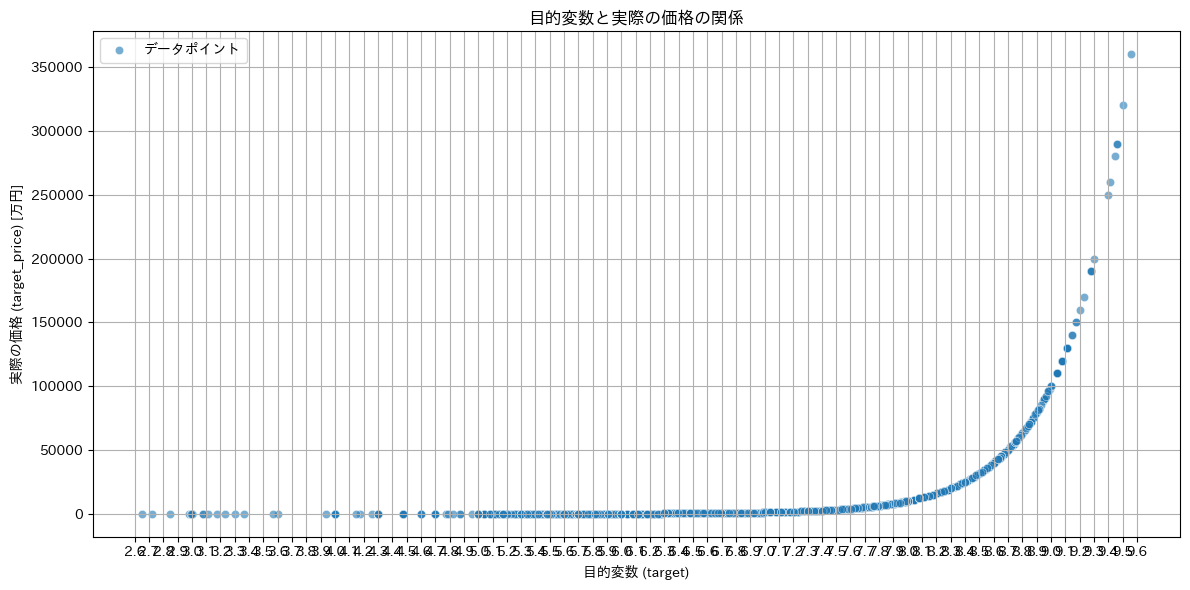

C:\Users\yuto2\AppData\Local\Temp\ipykernel_20032\3145467605.py:115: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)
C:\Users\yuto2\AppData\Local\Temp\ipykernel_20032\3145467605.py:128: UserWarning: Legend does not support handles for Axes instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend(handles=handles, labels=labels, title='データポイント', bbox_to_anchor=(1.05, 1), loc='upper left')


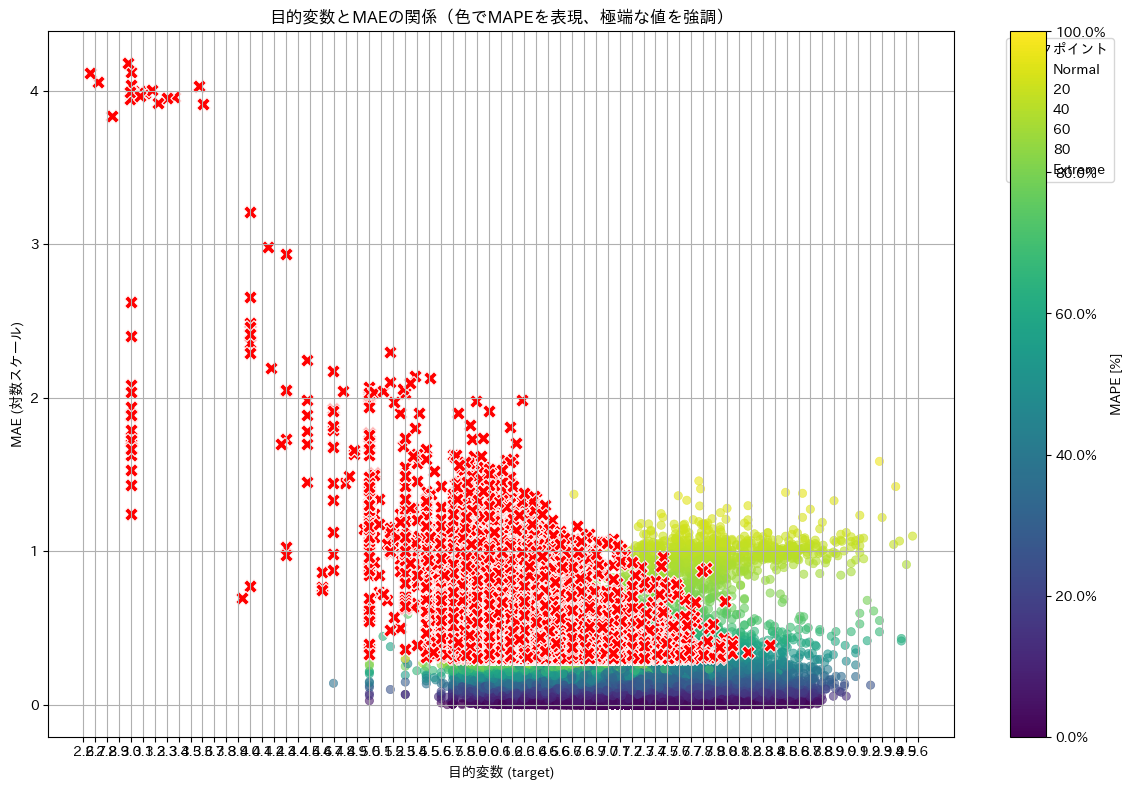

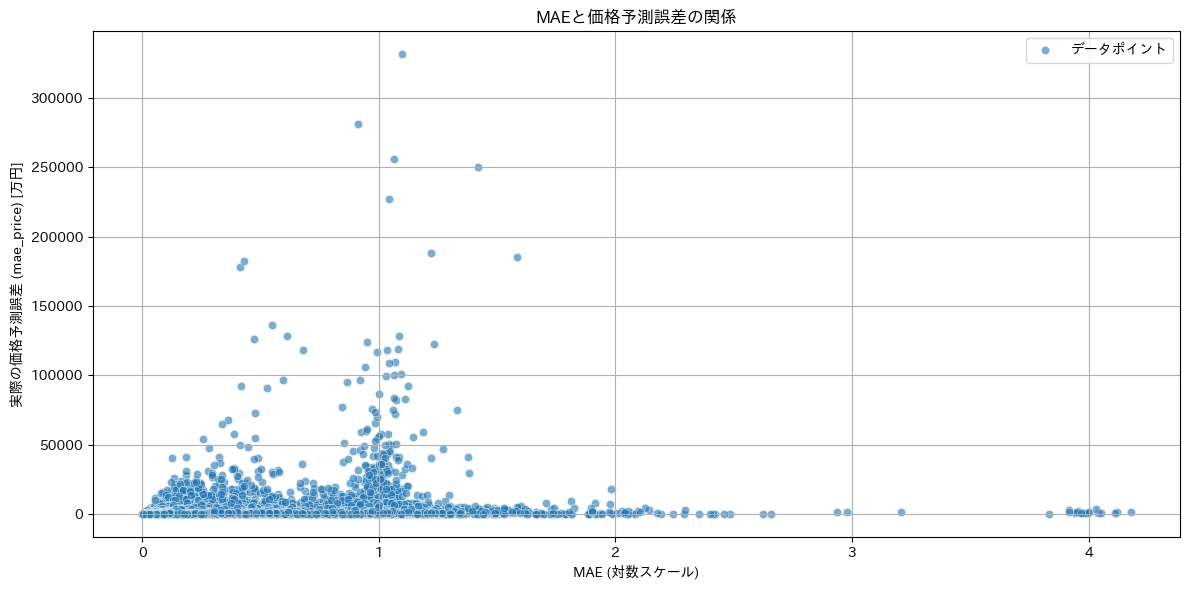

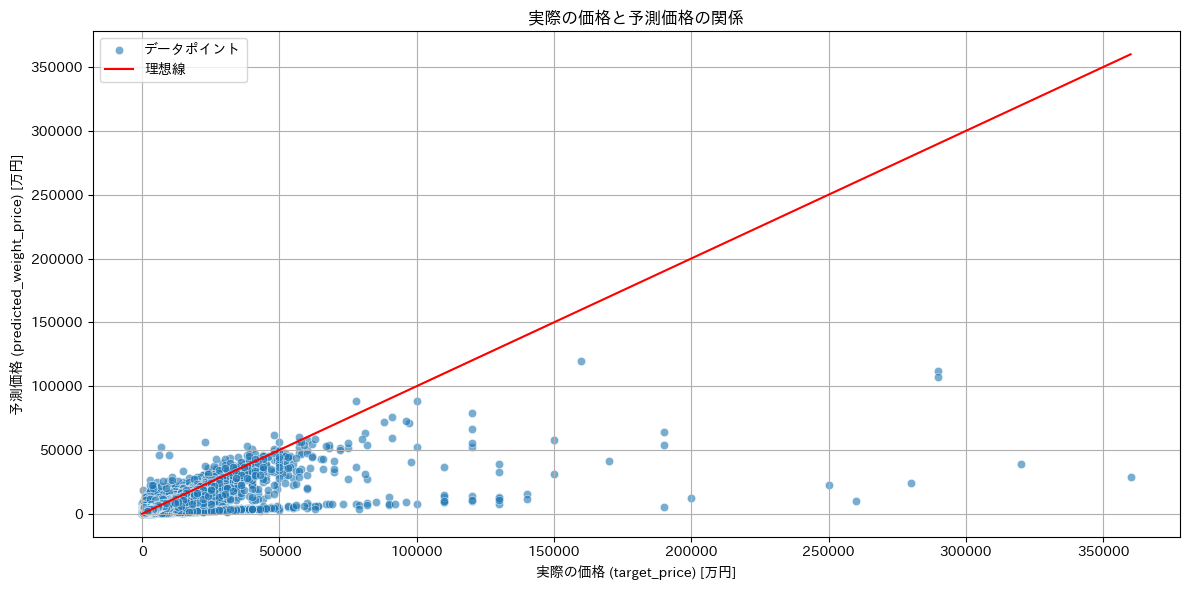

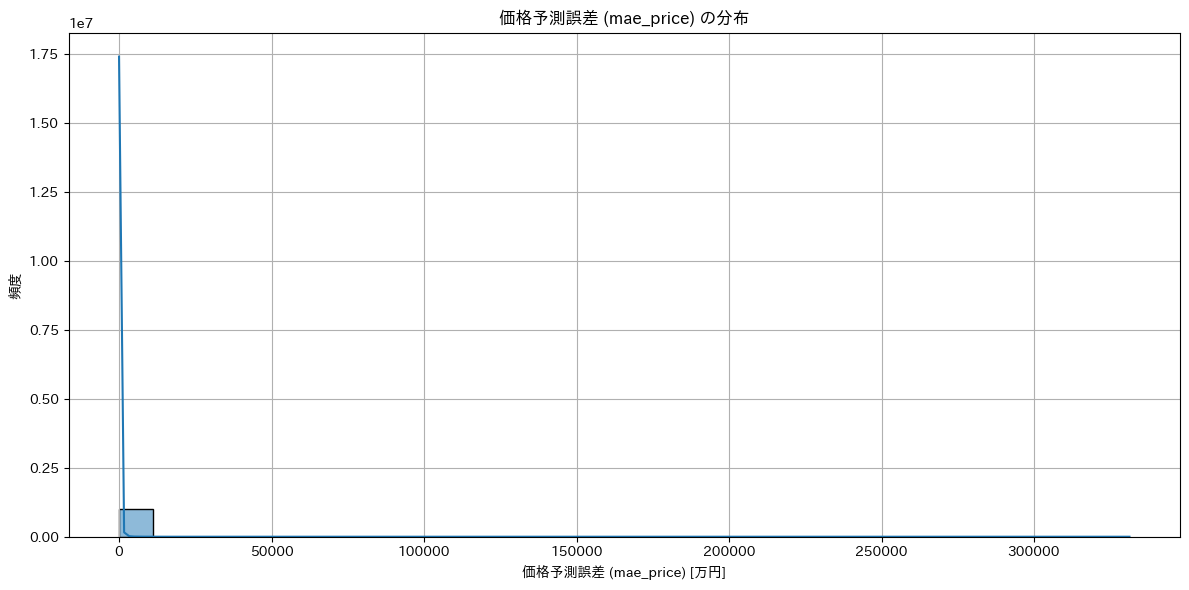

C:\Users\yuto2\AppData\Local\Temp\ipykernel_20032\3145467605.py:170: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = train_preds_df[['target', 'mae', 'mae_price', 'mape_price', 'mape_price_capped', 'error_category', 'target_price', 'pred_weight', 'predicted_weight_price']].corr()


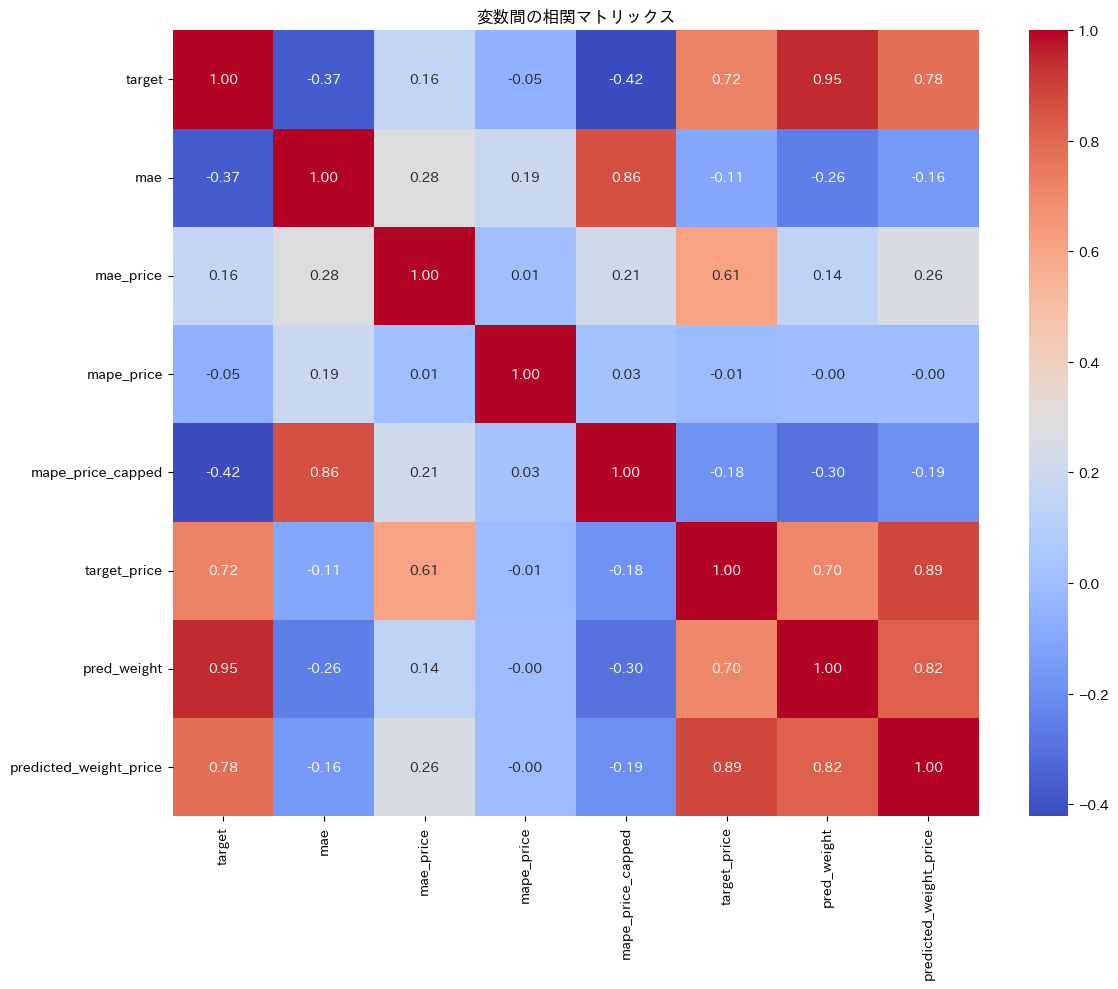

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.ticker as ticker



# target_priceの計算（targetがlog10(price)の場合）
train_preds_df["target_price"] = 10 ** train_preds_df["target"] / 10000

# 平均絶対誤差（MAE）の計算（対数スケール）
train_preds_df["mae"] = abs(train_preds_df["target"] - train_preds_df["pred_weight"])

# target_priceが一定の値以上の行を削除する
threshold = 800000  # ここで削除したいtarget_priceの閾値を設定
if threshold is not None:
    train_preds_df = train_preds_df[train_preds_df["target_price"] < threshold]

# predicted_weight_priceの計算（pred_weightがlog10(price)の場合）
train_preds_df["predicted_weight_price"] = 10 ** train_preds_df["pred_weight"] / 10000

# mae_priceの計算（価格スケールでの誤差）
train_preds_df["mae_price"] = abs(train_preds_df["target_price"] - train_preds_df["predicted_weight_price"])

# mape_priceの計算（価格スケールでの誤差率）
train_preds_df["mape_price"] = abs((train_preds_df["target_price"] - train_preds_df["predicted_weight_price"]) / train_preds_df["target_price"]) * 100

# mape_priceの上限を設定（例: 100%）
max_mape = 100
train_preds_df["mape_price_capped"] = train_preds_df["mape_price"].clip(upper=max_mape)

# 極端な誤差を別のカテゴリに分類
train_preds_df["error_category"] = np.where(train_preds_df["mape_price"] > max_mape, 'Extreme', 'Normal')

# 上位10%の誤差が大きい物件を抽出
high_error_df = train_preds_df[train_preds_df['mae'] >= train_preds_df['mae'].quantile(0.9)]

# 下位10%の誤差が小さい物件を抽出
low_error_df = train_preds_df[train_preds_df['mae'] <= train_preds_df['mae'].quantile(0.1)]

# 結果の表示
print("Filtered DataFrame:")
print(train_preds_df.head())

print("\nHigh Error DataFrame:")
print(high_error_df.head())

print("\nLow Error DataFrame:")
print(low_error_df.head())

# x軸のメモリを0.1刻みに設定するための範囲計算
min_target = train_preds_df['target'].min()
max_target = train_preds_df['target'].max()
x_ticks = np.arange(np.floor(min_target * 10) / 10, np.ceil(max_target * 10) / 10 + 0.1, 0.1)

# グラフのスタイル設定（オプション）
#sns.set(style="whitegrid")

# 1. 目的変数と実際の価格の関係を可視化
plt.figure(figsize=(12, 6))
sns.scatterplot(x='target', y='target_price', data=train_preds_df, alpha=0.6, label='データポイント')
# sns.regplot(x='target', y='target_price', data=train_preds_df, scatter=False, color='red', label='回帰線')

plt.title('目的変数と実際の価格の関係')
plt.xlabel('目的変数 (target)')
plt.ylabel('実際の価格 (target_price) [万円]')
plt.xticks(x_ticks)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. 目的変数とMAEの関係を可視化（MAPEを色で表現、極端な値を強調）
plt.figure(figsize=(12, 8))
# 通常のデータポイント
normal_data = train_preds_df[train_preds_df["error_category"] == 'Normal']
# 極端なデータポイント
extreme_data = train_preds_df[train_preds_df["error_category"] == 'Extreme']

# 通常のデータポイントをカラーマップでプロット
scatter_normal = sns.scatterplot(
    x='target',
    y='mae',
    hue='mape_price_capped',
    palette='viridis',
    data=normal_data,
    alpha=0.6,
    edgecolor=None,
    label='Normal'
)

# 極端なデータポイントを特定の色（例: 赤）でプロット
scatter_extreme = sns.scatterplot(
    x='target',
    y='mae',
    data=extreme_data,
    color='red',
    marker='X',  # マーカーを変える
    s=100,       # サイズを大きくする
    label='Extreme'
)

plt.title('目的変数とMAEの関係（色でMAPEを表現、極端な値を強調）')
plt.xlabel('目的変数 (target)')
plt.ylabel('MAE (対数スケール)')
plt.xticks(x_ticks)
plt.grid(True)
plt.tight_layout()

# カラーバーの追加
norm = plt.Normalize(normal_data['mape_price_capped'].min(), normal_data['mape_price_capped'].max())
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('MAPE [%]')

# カラーバーの目盛りをパーセンテージとして表示
cbar_ticks = cbar.get_ticks()
cbar_tick_labels = [f"{tick:.1f}%" for tick in cbar_ticks]
cbar.set_ticks(cbar_ticks)
cbar.set_ticklabels(cbar_tick_labels)

# 凡例のカスタマイズ
handles, labels = scatter_normal.get_legend_handles_labels()
handles = handles[0:len(normal_data['mape_price_capped'].unique())] + [scatter_extreme]
labels = labels[0:len(normal_data['mape_price_capped'].unique())] + ['Extreme']
plt.legend(handles=handles, labels=labels, title='データポイント', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

# 3. MAEの値に対する実際の価格予測誤差 (mae_price) の関係を可視化
plt.figure(figsize=(12, 6))
sns.scatterplot(x='mae', y='mae_price', data=train_preds_df, alpha=0.6, label='データポイント')
# sns.regplot(x='mae', y='mae_price', data=train_preds_df, scatter=False, color='red', label='回帰線')

plt.title('MAEと価格予測誤差の関係')
plt.xlabel('MAE (対数スケール)')
plt.ylabel('実際の価格予測誤差 (mae_price) [万円]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 実際の価格 vs 予測価格
plt.figure(figsize=(12, 6))
sns.scatterplot(x='target_price', y='predicted_weight_price', data=train_preds_df, alpha=0.6, label='データポイント')
sns.lineplot(x='target_price', y='target_price', data=train_preds_df, color='red', label='理想線')

plt.title('実際の価格と予測価格の関係')
plt.xlabel('実際の価格 (target_price) [万円]')
plt.ylabel('予測価格 (predicted_weight_price) [万円]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 誤差のヒストグラム
plt.figure(figsize=(12, 6))
sns.histplot(train_preds_df['mae_price'], bins=30, kde=True)

plt.title('価格予測誤差 (mae_price) の分布')
plt.xlabel('価格予測誤差 (mae_price) [万円]')
plt.ylabel('頻度')
plt.grid(True)
plt.tight_layout()
plt.show()

# 相関マトリックスのヒートマップ
correlation_matrix = train_preds_df[['target', 'mae', 'mae_price', 'mape_price', 'mape_price_capped', 'error_category', 'target_price', 'pred_weight', 'predicted_weight_price']].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

plt.title('変数間の相関マトリックス')
plt.tight_layout()
plt.show()


Filtered DataFrame:
            価格情報区分 都道府県名   市区町村名    地区名  住所不一致_Flag              住所 最寄駅：名称  \
ID                                                                           
1046933  不動産取引価格情報   北海道  札幌市白石区    南郷通           0    北海道札幌市白石区南郷通  南郷７丁目   
1079053  不動産取引価格情報   北海道   札幌市西区  発寒１２条           0   北海道札幌市西区発寒１２条   発寒中央   
1170588     成約価格情報   北海道     江別市   大麻北町           0      北海道江別市大麻北町   森林公園   
1001637     成約価格情報   北海道  札幌市中央区   北５条西           0   北海道札幌市中央区北５条西  西２８丁目   
1014790  不動産取引価格情報   北海道  札幌市中央区  宮の森２条           0  北海道札幌市中央区宮の森２条  西２８丁目   

         最寄駅：距離（分）  徒歩時間_10分単位       x_api  ...  pred_lgbm  pred_cat  \
ID                                          ...                        
1046933        4.0         0.0  141.396484  ...   7.232717  7.218212   
1079053       11.0        10.0  141.297836  ...   7.081142  7.087704   
1170588        NaN         NaN  141.500595  ...   6.978727  6.999186   
1001637        6.0         0.0  141.354538  ...   7.463736  7.485380   
1

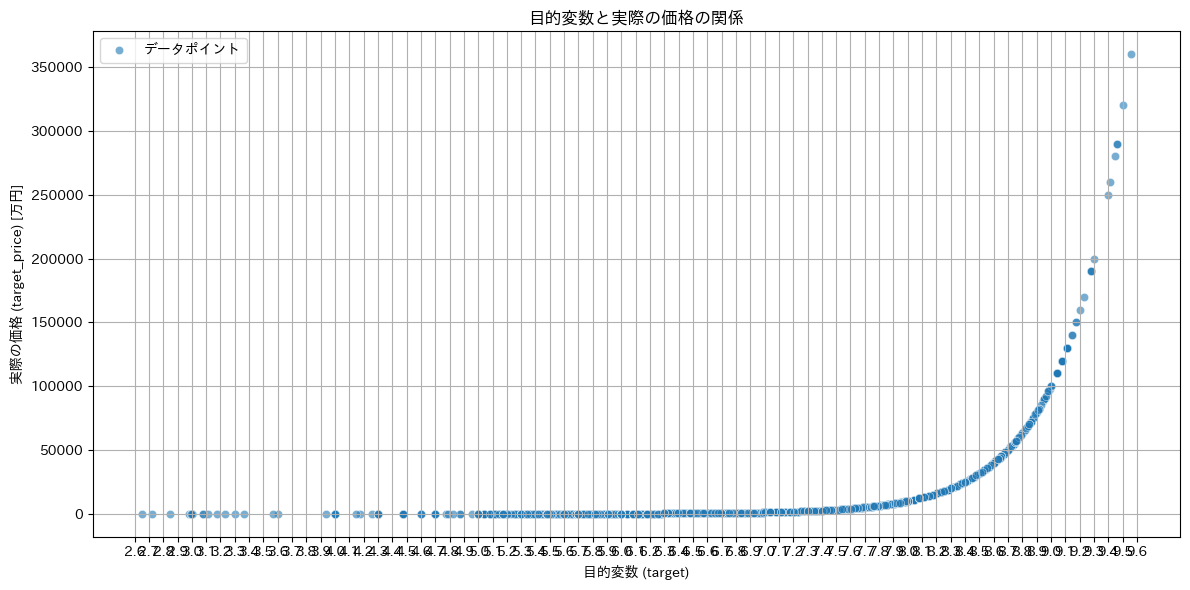

C:\Users\yuto2\AppData\Local\Temp\ipykernel_20032\208699440.py:87: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


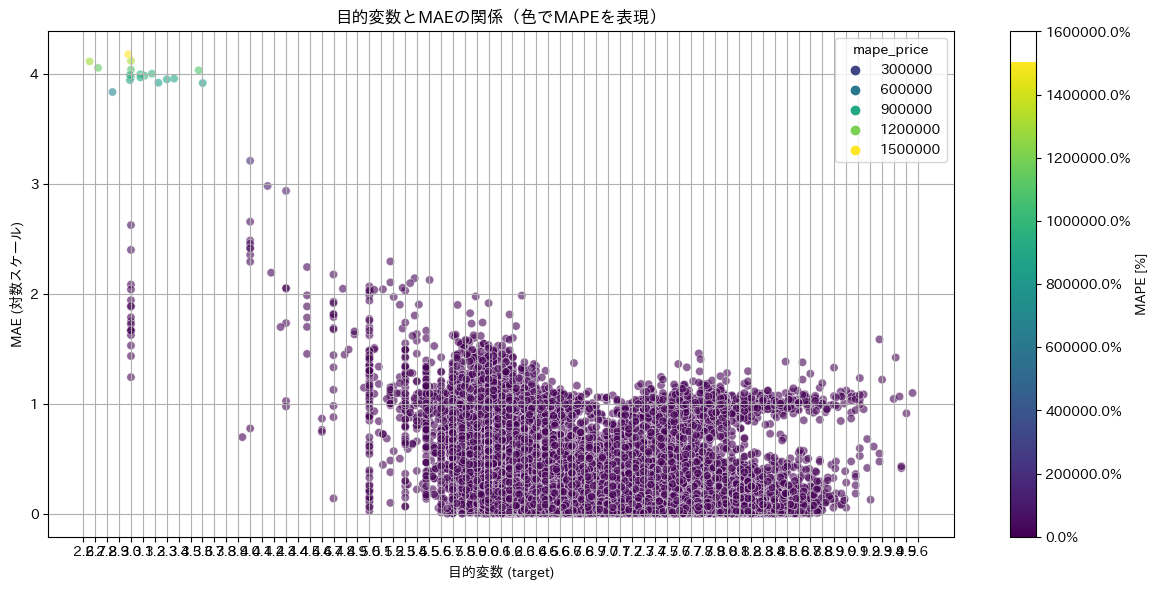

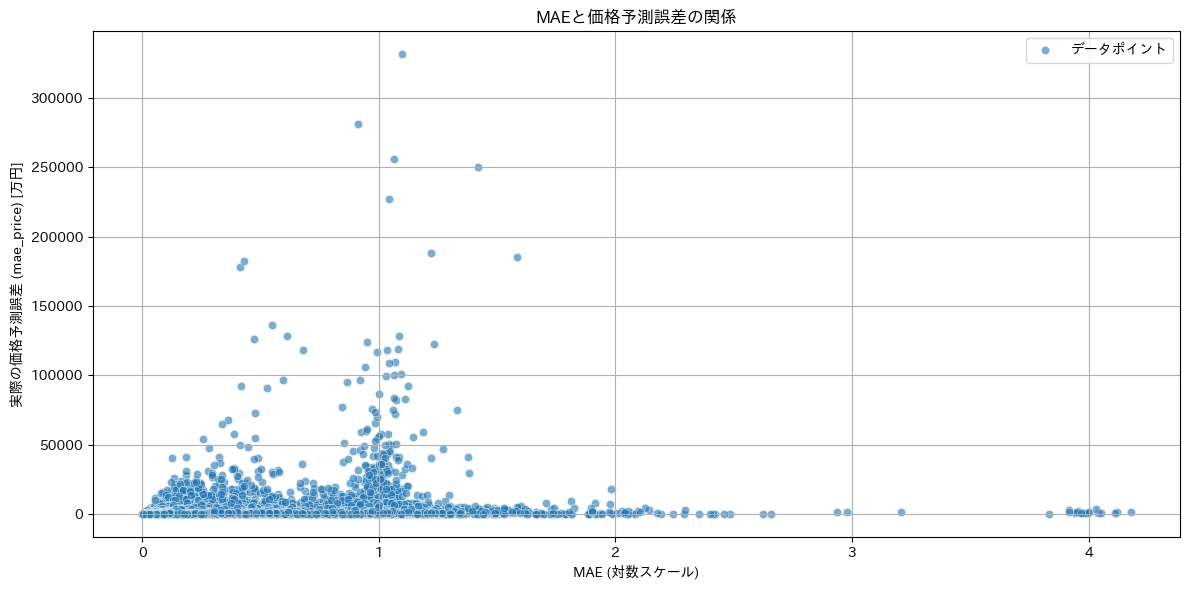

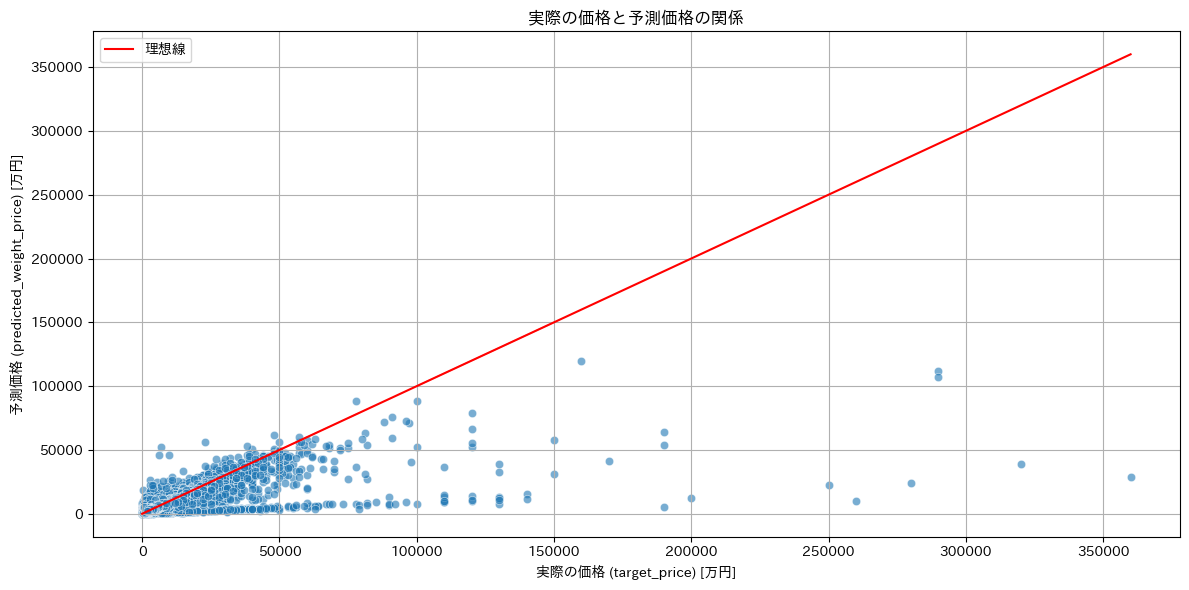

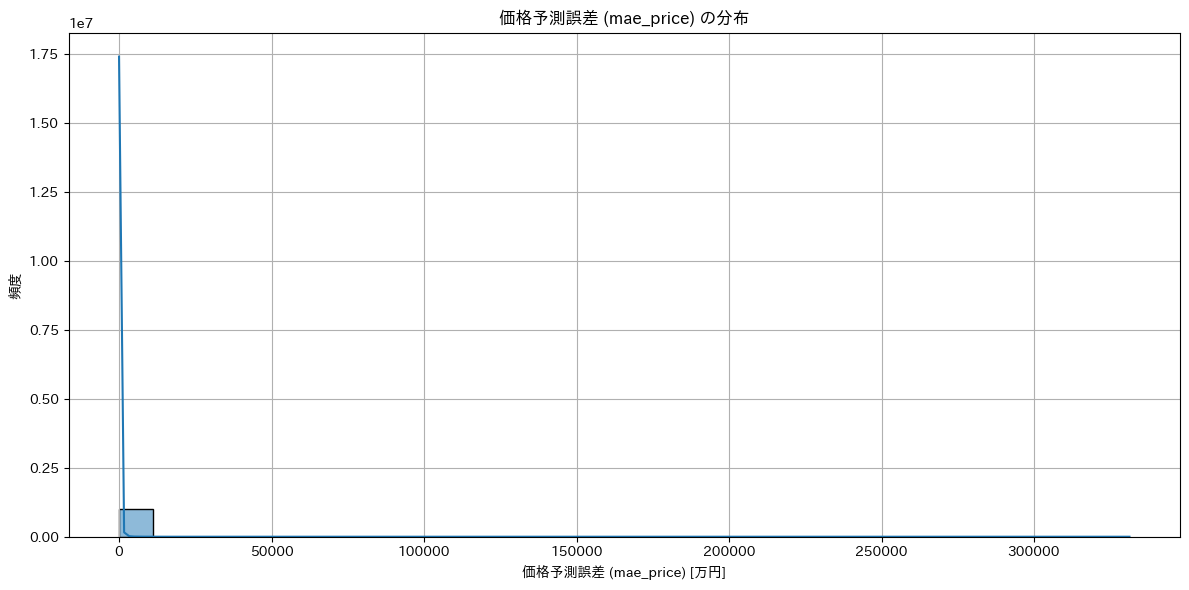

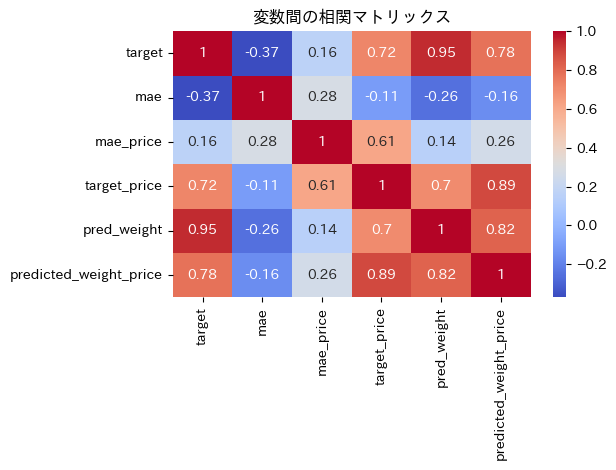

In [8]:
# target_priceの計算（targetがlog10(price)の場合）
train_preds_df["target_price"] = 10 ** train_preds_df["target"] / 10000

# 平均絶対誤差（MAE）の計算（対数スケール）
train_preds_df["mae"] = abs(train_preds_df["target"] - train_preds_df["pred_weight"])

# target_priceが一定の値以上の行を削除する
threshold = 800000  # ここで削除したいtarget_priceの閾値を設定
if threshold is not None:
    train_preds_df = train_preds_df[train_preds_df["target_price"] < threshold]

# predicted_weight_priceの計算（pred_weightがlog10(price)の場合）
train_preds_df["predicted_weight_price"] = 10 ** train_preds_df["pred_weight"] / 10000

# mae_priceの計算（価格スケールでの誤差）
train_preds_df["mae_price"] = abs(train_preds_df["target_price"] - train_preds_df["predicted_weight_price"])

# mape_priceの計算（��格スケールでの��差率）
train_preds_df["mape_price"] = abs((train_preds_df["target_price"] - train_preds_df["predicted_weight_price"]) / train_preds_df["target_price"]) * 100


# 上位10%の誤差が大きい物件を抽出
high_error_df = train_preds_df[train_preds_df['mae'] >= train_preds_df['mae'].quantile(0.9)]

# 下位10%の誤差が小さい物件を抽出
low_error_df = train_preds_df[train_preds_df['mae'] <= train_preds_df['mae'].quantile(0.1)]

# 結果の表示
print("Filtered DataFrame:")
print(train_preds_df.head())

print("\nHigh Error DataFrame:")
print(high_error_df.head())

print("\nLow Error DataFrame:")
print(low_error_df.head())

# x軸のメモリを0.1刻みに設定するための範囲計算
min_target = train_preds_df['target'].min()
max_target = train_preds_df['target'].max()
x_ticks = np.arange(np.floor(min_target * 10) / 10, np.ceil(max_target * 10) / 10 + 0.1, 0.1)

# グラフのスタイル設定（オプション）
#sns.set(style="whitegrid")

# 1. 目的変数と実際の価格の関係を可視化
plt.figure(figsize=(12, 6))
sns.scatterplot(x='target', y='target_price', data=train_preds_df, alpha=0.6, label='データポイント')
#sns.regplot(x='target', y='target_price', data=train_preds_df, scatter=False, color='red', label='回帰線')

plt.title('目的変数と実際の価格の関係')
plt.xlabel('目的変数 (target)')
plt.ylabel('実際の価格 (target_price) [万円]')
plt.xticks(x_ticks)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. 目的変数とMAEの関係を可視化（target_priceを色で表現）
train_preds_df["log_target_price"] = np.log10(train_preds_df["target_price"])
train_preds_df["log_mae_price"] = np.log10(train_preds_df["mae_price"])

plt.figure(figsize=(12, 6))
scatter = sns.scatterplot(
    x='target',
    y='mae',
    #hue='log_target_price',
    #hue='log_mae_price',
    hue='mape_price',
    palette='viridis',
    data=train_preds_df,
    alpha=0.6
)

plt.title('目的変数とMAEの関係（色でMAPEを表現）')
plt.xlabel('目的変数 (target)')
plt.ylabel('MAE (対数スケール)')
plt.xticks(x_ticks)
plt.grid(True)
plt.tight_layout()

# カラーバーの追加
norm = plt.Normalize(train_preds_df['mape_price'].min(), train_preds_df['mape_price'].max())
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('MAPE [%]')

# カラーバーの目盛りを実際の価格に変換
#cbar_ticks = cbar.get_ticks()
#cbar_tick_labels = [f"{10**tick:.1f}" for tick in cbar_ticks]
#cbar.set_ticks(cbar_ticks)
#cbar.set_ticklabels(cbar_tick_labels)

# カラーバーの目盛りをパーセンテージとして表示
cbar_ticks = cbar.get_ticks()
cbar_tick_labels = [f"{tick:.1f}%" for tick in cbar_ticks]
cbar.set_ticks(cbar_ticks)
cbar.set_ticklabels(cbar_tick_labels)

plt.show()


# 3. MAEの値に対する実際の価格予測誤差 (mae_price) の関係を可視化
plt.figure(figsize=(12, 6))
sns.scatterplot(x='mae', y='mae_price', data=train_preds_df, alpha=0.6, label='データポイント')
#sns.regplot(x='mae', y='mae_price', data=train_preds_df, scatter=False, color='red', label='回帰線')

plt.title('MAEと価格予測誤差の関係')
plt.xlabel('MAE (対数スケール)')
plt.ylabel('実際の価格予測誤差 (mae_price) [万円]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# 実際の価格 vs 予測価格
plt.figure(figsize=(12, 6))
sns.scatterplot(x='target_price', y='predicted_weight_price', data=train_preds_df, alpha=0.6)
sns.lineplot(x='target_price', y='target_price', data=train_preds_df, color='red', label='理想線')

plt.title('実際の価格と予測価格の関係')
plt.xlabel('実際の価格 (target_price) [万円]')
plt.ylabel('予測価格 (predicted_weight_price) [万円]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 誤差のヒストグラム
plt.figure(figsize=(12, 6))
sns.histplot(train_preds_df['mae_price'], bins=30, kde=True)

plt.title('価格予測誤差 (mae_price) の分布')
plt.xlabel('価格予測誤差 (mae_price) [万円]')
plt.ylabel('頻度')
plt.grid(True)
plt.tight_layout()
plt.show()




correlation_matrix = train_preds_df[['target', 'mae', 'mae_price', 'target_price', 'pred_weight', 'predicted_weight_price']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

plt.title('変数間の相関マトリックス')
plt.tight_layout()
plt.show()


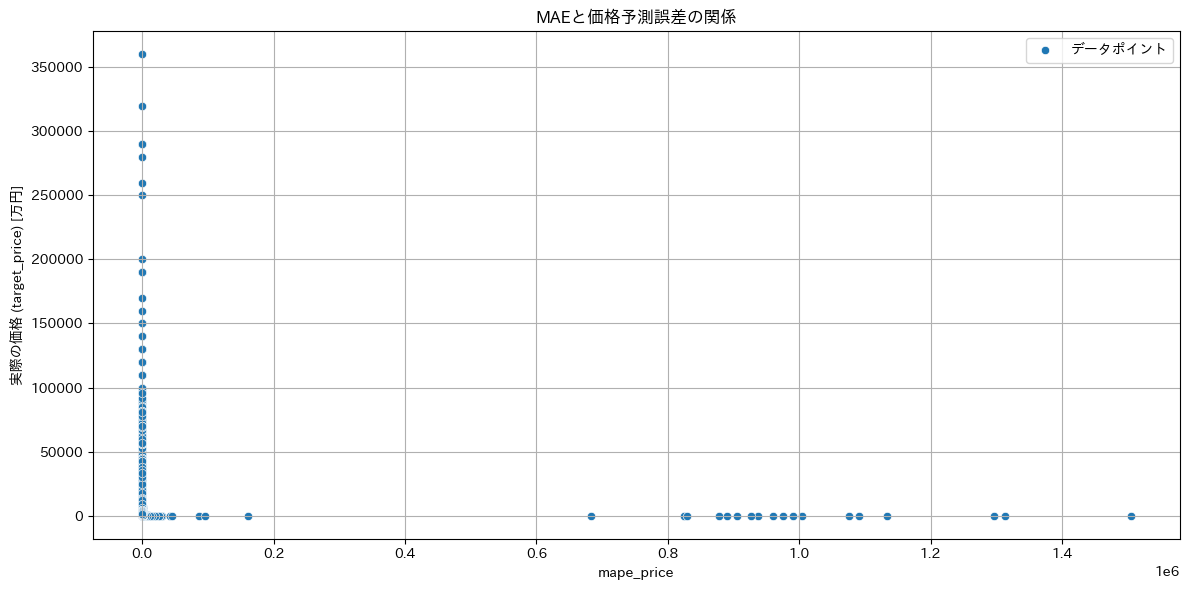

In [9]:
# target_priceの計算（targetがlog10(price)の場合）
train_preds_df["target_price"] = 10 ** train_preds_df["target"] / 10000

# 平均絶対誤差（MAE）の計算（対数スケール）
train_preds_df["mae"] = abs(train_preds_df["target"] - train_preds_df["pred_weight"])

# target_priceが一定の値以上の行を削除する
threshold = 800000  # ここで削除したいtarget_priceの閾値を設定
if threshold is not None:
    train_preds_df = train_preds_df[train_preds_df["target_price"] < threshold]

# predicted_weight_priceの計算（pred_weightがlog10(price)の場合）
train_preds_df["predicted_weight_price"] = 10 ** train_preds_df["pred_weight"] / 10000

# mae_priceの計算（価格スケールでの誤差）
train_preds_df["mae_price"] = abs(train_preds_df["target_price"] - train_preds_df["predicted_weight_price"])

# mape_priceの計算（価格スケールでの誤差率）
train_preds_df["mape_price"] = abs((train_preds_df["target_price"] - train_preds_df["predicted_weight_price"]) / train_preds_df["target_price"]) * 100

# 3. MAEの値に対する実際の価格予測誤差 (mae_price) の関係を可視化
plt.figure(figsize=(12, 6))
sns.scatterplot(x='mape_price', y='target_price', data=train_preds_df,  label='データポイント')
#sns.regplot(x='mae', y='mae_price', data=train_preds_df, scatter=False, color='red', label='回帰線')

plt.title('MAEと価格予測誤差の関係')
plt.xlabel('mape_price')
plt.ylabel('実際の価格 (target_price) [万円]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

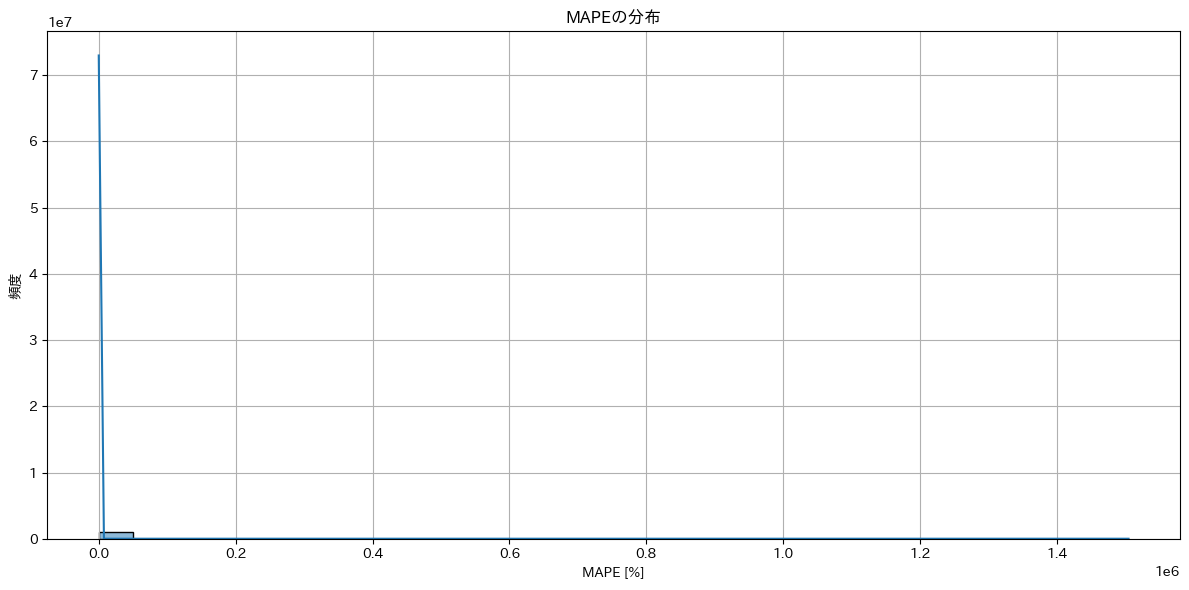

In [10]:
plt.figure(figsize=(12, 6))
sns.histplot(train_preds_df['mape_price'], bins=30, kde=True)

plt.title('MAPEの分布')
plt.xlabel('MAPE [%]')
plt.ylabel('頻度')
plt.grid(True)
plt.tight_layout()
plt.show()


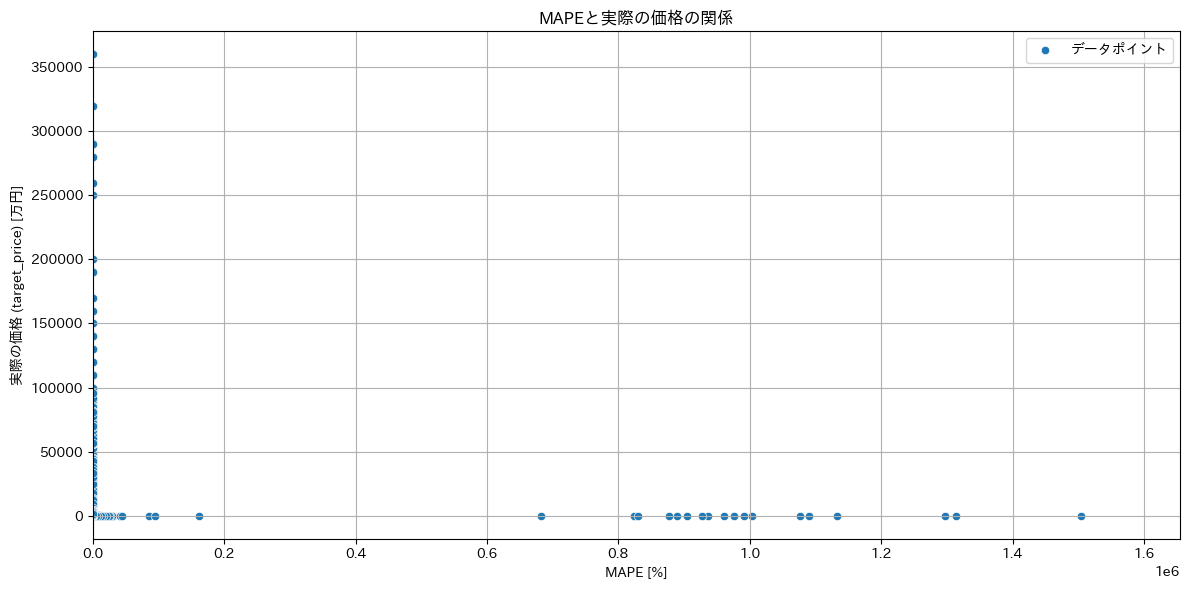

In [11]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='mape_price', y='target_price', data=train_preds_df, label='データポイント')

plt.title('MAPEと実際の価格の関係')
plt.xlabel('MAPE [%]')
plt.ylabel('実際の価格 (target_price) [万円]')
plt.legend()
plt.grid(True)
plt.tight_layout()

# x軸の範囲を設定（必要に応じて調整）
plt.xlim(0, train_preds_df['mape_price'].max() * 1.1)  # 最大値の10%余裕を持たせる
plt.show()


In [12]:
print(abc)

NameError: name 'abc' is not defined

In [ ]:
# target_priceの計算（targetがlog10(price)の場合）
train_preds_df["target_price"] = 10 ** train_preds_df["target"] / 10000

# 平均絶対誤差（MAE）の計算（対数スケール）
train_preds_df["mae"] = abs(train_preds_df["target"] - train_preds_df["pred_weight"])

# target_priceが一定の値以上の行を削除する
threshold = 800000  # ここで削除したいtarget_priceの閾値を設定
if threshold is not None:
    train_preds_df = train_preds_df[train_preds_df["target_price"] < threshold]

# predicted_weight_priceの計算（pred_weightがlog10(price)の場合）
train_preds_df["predicted_weight_price"] = 10 ** train_preds_df["pred_weight"] / 10000

# mae_priceの計算（価格スケールでの誤差）
train_preds_df["mae_price"] = abs(train_preds_df["target_price"] - train_preds_df["predicted_weight_price"])

# 上位10%の誤差が大きい物件を抽出
high_error_df = train_preds_df[train_preds_df['mae'] >= train_preds_df['mae'].quantile(0.9)]

# 下位10%の誤差が小さい物件を抽出
low_error_df = train_preds_df[train_preds_df['mae'] <= train_preds_df['mae'].quantile(0.1)]

# 結果の表示
print("Filtered DataFrame:")
print(train_preds_df.head())

print("\nHigh Error DataFrame:")
print(high_error_df.head())

print("\nLow Error DataFrame:")
print(low_error_df.head())

# x軸のメモリを0.1刻みに設定するための範囲計算
min_target = train_preds_df['target'].min()
max_target = train_preds_df['target'].max()
x_ticks = np.arange(np.floor(min_target * 10) / 10, np.ceil(max_target * 10) / 10 + 0.1, 0.1)

# グラフのスタイル設定（オプション）
#sns.set(style="whitegrid")

# 1. 目的変数と実際の価格の関係を可視化
plt.figure(figsize=(12, 6))
sns.scatterplot(x='target', y='target_price', data=train_preds_df, alpha=0.6, label='データポイント')
#sns.regplot(x='target', y='target_price', data=train_preds_df, scatter=False, color='red', label='回帰線')

plt.title('目的変数と実際の価格の関係')
plt.xlabel('目的変数 (target)')
plt.ylabel('実際の価格 (target_price) [万円]')
plt.xticks(x_ticks)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. 目的変数とMAEの関係を可視化（target_priceを色で表現）
plt.figure(figsize=(12, 6))
scatter = sns.scatterplot(
    x='target',
    y='mae',
    #hue='target_price',
    hue="mae_price",
    palette='viridis',
    data=train_preds_df,
    alpha=0.6
)

plt.title('目的変数とMAEの関係（色で実際の価格を表現）')
plt.xlabel('目的変数 (target)')
plt.ylabel('MAE (対数スケール)')
plt.xticks(x_ticks)
plt.legend(title='実際の価格\n(target_price) [万円]', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. MAEの値に対する実際の価格予測誤差 (mae_price) の関係を可視化
plt.figure(figsize=(12, 6))
sns.scatterplot(x='mae', y='mae_price', data=train_preds_df, alpha=0.6, label='データポイント')
#sns.regplot(x='mae', y='mae_price', data=train_preds_df, scatter=False, color='red', label='回帰線')

plt.title('MAEと価格予測誤差の関係')
plt.xlabel('MAE (対数スケール)')
plt.ylabel('実際の価格予測誤差 (mae_price) [万円]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# ダミーデータの作成
np.random.seed(0)
train_preds_df = pd.DataFrame({
    'target': np.random.uniform(0, 5, 1000),
    'pred_weight': np.random.uniform(0, 5, 1000)
})

# 計算部分
train_preds_df["target_price"] = 10 ** train_preds_df["target"] / 10000
train_preds_df["mae"] = abs(train_preds_df["target"] - train_preds_df["pred_weight"])
train_preds_df["predicted_weight_price"] = 10 ** train_preds_df["pred_weight"] / 10000
train_preds_df["mae_price"] = abs(train_preds_df["target_price"] - train_preds_df["predicted_weight_price"])

# ランキングの計算
train_preds_df['mae_price_rank'] = train_preds_df['mae_price'].rank(method='min', ascending=True)

# ランキングの正規化
scaler = MinMaxScaler()
train_preds_df['mae_price_rank_normalized'] = scaler.fit_transform(train_preds_df[['mae_price_rank']])

# プロットの準備
fig, axes = plt.subplots(1, 2, figsize=(24, 6), sharey=True)

# プロット1: ランキングを色に使用
sns.scatterplot(
    ax=axes[0],
    x='target',
    y='mae',
    hue='mae_price_rank',
    palette='viridis',
    data=train_preds_df,
    alpha=0.6,
    edgecolor=None
)
axes[0].set_title('mae_priceのランキングで色分け', fontsize=16)
axes[0].set_xlabel('目的変数 (target)', fontsize=14)
axes[0].set_ylabel('MAE (対数スケール)', fontsize=14)
axes[0].legend(title='mae_price Rank', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].grid(True)

# プロット2: 正規化されたランキングを色に使用
scatter = sns.scatterplot(
    ax=axes[1],
    x='target',
    y='mae',
    hue='mae_price_rank_normalized',
    palette='viridis',
    data=train_preds_df,
    alpha=0.6,
    edgecolor=None
)
axes[1].set_title('mae_priceの正規化ランキングで色分け', fontsize=16)
axes[1].set_xlabel('目的変数 (target)', fontsize=14)
axes[1].set_ylabel('MAE (対数スケール)', fontsize=14)
axes[1].legend([], [], frameon=False)
axes[1].grid(True)

# カラーバーの追加（正規化されたランキングのみ）
norm = plt.Normalize(train_preds_df['mae_price_rank_normalized'].min(), train_preds_df['mae_price_rank_normalized'].max())
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('mae_price ランキング（正規化）', fontsize=12)
cbar_ticks = [0.0, 0.25, 0.5, 0.75, 1.0]
cbar.set_ticks(cbar_ticks)
max_rank = train_preds_df['mae_price_rank'].max()
cbar_tick_labels = [f"{int(tick * max_rank)}" for tick in cbar_ticks]
cbar.set_ticklabels(cbar_tick_labels)

plt.tight_layout()
plt.show()


Filtered DataFrame:
            価格情報区分 都道府県名   市区町村名    地区名  住所不一致_Flag              住所 最寄駅：名称  \
ID                                                                           
1046933  不動産取引価格情報   北海道  札幌市白石区    南郷通           0    北海道札幌市白石区南郷通  南郷７丁目   
1079053  不動産取引価格情報   北海道   札幌市西区  発寒１２条           0   北海道札幌市西区発寒１２条   発寒中央   
1170588     成約価格情報   北海道     江別市   大麻北町           0      北海道江別市大麻北町   森林公園   
1001637     成約価格情報   北海道  札幌市中央区   北５条西           0   北海道札幌市中央区北５条西  西２８丁目   
1014790  不動産取引価格情報   北海道  札幌市中央区  宮の森２条           0  北海道札幌市中央区宮の森２条  西２８丁目   

         最寄駅：距離（分）  徒歩時間_10分単位       x_api  ...       mae  \
ID                                          ...             
1046933        4.0         0.0  141.396484  ...  0.076080   
1079053       11.0        10.0  141.297836  ...  0.043204   
1170588        NaN         NaN  141.500595  ...  0.221932   
1001637        6.0         0.0  141.354538  ...  0.012660   
1014790       10.0        10.0  141.311798  ...  0.009754   

     

C:\Users\yuto2\AppData\Local\Temp\ipykernel_20032\2959740140.py:68: UserWarning: Glyph 30446 (\N{CJK UNIFIED IDEOGRAPH-76EE}) missing from current font.
  plt.tight_layout()
C:\Users\yuto2\AppData\Local\Temp\ipykernel_20032\2959740140.py:68: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from current font.
  plt.tight_layout()
C:\Users\yuto2\AppData\Local\Temp\ipykernel_20032\2959740140.py:68: UserWarning: Glyph 22793 (\N{CJK UNIFIED IDEOGRAPH-5909}) missing from current font.
  plt.tight_layout()
C:\Users\yuto2\AppData\Local\Temp\ipykernel_20032\2959740140.py:68: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  plt.tight_layout()
C:\Users\yuto2\AppData\Local\Temp\ipykernel_20032\2959740140.py:68: UserWarning: Glyph 23455 (\N{CJK UNIFIED IDEOGRAPH-5B9F}) missing from current font.
  plt.tight_layout()
C:\Users\yuto2\AppData\Local\Temp\ipykernel_20032\2959740140.py:68: UserWarning: Glyph 38555 (\N{CJK UNIFIED IDEOGRAPH-969B}) miss

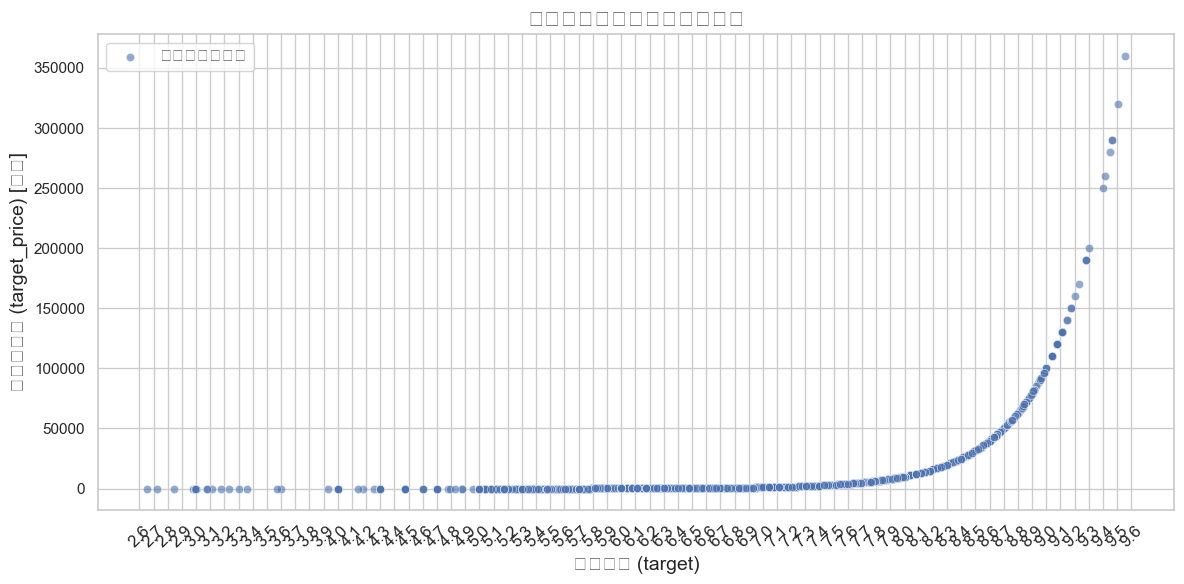

C:\Users\yuto2\AppData\Local\Temp\ipykernel_20032\2959740140.py:92: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)
C:\Users\yuto2\AppData\Local\Temp\ipykernel_20032\2959740140.py:105: UserWarning: Glyph 30446 (\N{CJK UNIFIED IDEOGRAPH-76EE}) missing from current font.
  plt.tight_layout()
C:\Users\yuto2\AppData\Local\Temp\ipykernel_20032\2959740140.py:105: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from current font.
  plt.tight_layout()
C:\Users\yuto2\AppData\Local\Temp\ipykernel_20032\2959740140.py:105: UserWarning: Glyph 22793 (\N{CJK UNIFIED IDEOGRAPH-5909}) missing from current font.
  plt.tight_layout()
C:\Users\yuto2\AppData\Local\Temp\ipykernel_20032\2959740140.py:105: UserWarning: Glyph 25968 (\N{CJK U

KeyboardInterrupt: 

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.ticker as mticker


# target_priceの計算（targetがlog10(price)の場合）
train_preds_df["target_price"] = 10 ** train_preds_df["target"] / 10000

# 平均絶対誤差（MAE）の計算
train_preds_df["mae"] = abs(train_preds_df["target"] - train_preds_df["pred_weight"])

# target_priceが一定の値以上の行を削除する
threshold = 800000  # ここで削除したいtarget_priceの閾値を設定
if threshold is not None:
    train_preds_df = train_preds_df[train_preds_df["target_price"] < threshold]

# predicted_weight_priceの計算
train_preds_df["predicted_weight_price"] = 10 ** train_preds_df["pred_weight"] / 10000

# mae_priceの計算
train_preds_df["mae_price"] = abs(train_preds_df["target_price"] - train_preds_df["predicted_weight_price"])

# 上位10%の誤差が大きい物件を抽出
high_error_df = train_preds_df[train_preds_df['mae'] >= train_preds_df['mae'].quantile(0.9)]

# 下位10%の誤差が小さい物件を抽出
low_error_df = train_preds_df[train_preds_df['mae'] <= train_preds_df['mae'].quantile(0.1)]

# mae_priceのランキングを計算（同じ値は同じランク）
train_preds_df['mae_price_rank'] = train_preds_df['mae_price'].rank(method='min', ascending=True)

# ランキングを正規化
scaler = MinMaxScaler()
train_preds_df['mae_price_rank_normalized'] = scaler.fit_transform(train_preds_df[['mae_price_rank']])

# 結果の表示
print("Filtered DataFrame:")
print(train_preds_df.head())

print("\nHigh Error DataFrame:")
print(high_error_df.head())

print("\nLow Error DataFrame:")
print(low_error_df.head())

# x軸のメモリを0.1刻みに設定するための範囲計算
min_target = train_preds_df['target'].min()
max_target = train_preds_df['target'].max()
x_ticks = np.arange(np.floor(min_target * 10) / 10, np.ceil(max_target * 10) / 10 + 0.1, 0.1)

# グラフのスタイル設定（オプション）
#sns.set(style="whitegrid")

# 1. 目的変数と実際の価格の関係を可視化
plt.figure(figsize=(12, 6))
sns.scatterplot(x='target', y='target_price', data=train_preds_df, alpha=0.6, label='データポイント')
# sns.regplot(x='target', y='target_price', data=train_preds_df, scatter=False, color='red', label='回帰線')

plt.title('目的変数と実際の価格の関係', fontsize=16)
plt.xlabel('目的変数 (target)', fontsize=14)
plt.ylabel('実際の価格 (target_price) [万円]', fontsize=14)
plt.xticks(x_ticks, rotation=45, fontsize=12)  # ラベルを45度回転し、フォントサイズを調整
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. 目的変数とMAEの関係を可視化（mae_priceのランキングに基づく色分け）
plt.figure(figsize=(12, 6))
scatter = sns.scatterplot(
    x='target',
    y='mae',
    hue='mae_price_rank_normalized',
    palette='viridis',
    data=train_preds_df,
    alpha=0.6,
    edgecolor=None
)

plt.title('目的変数とMAEの関係（色でmae_priceのランキングを表現）', fontsize=16)
plt.xlabel('目的変数 (target)', fontsize=14)
plt.ylabel('MAE (対数スケール)', fontsize=14)
plt.xticks(x_ticks, rotation=45, fontsize=12)  # ラベルを45度回転し、フォントサイズを調整

# カラーバーの追加
norm = plt.Normalize(train_preds_df['mae_price_rank_normalized'].min(), train_preds_df['mae_price_rank_normalized'].max())
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('mae_price ランキング（正規化）', fontsize=12)

# カラーバーの目盛りをランキングに基づいてカスタマイズ
cbar_ticks = [0.0, 0.25, 0.5, 0.75, 1.0]
cbar.set_ticks(cbar_ticks)
max_rank = train_preds_df['mae_price_rank'].max()
cbar_tick_labels = [f"{int(tick * max_rank)}" for tick in cbar_ticks]
cbar.set_ticklabels(cbar_tick_labels)

plt.yticks(fontsize=12)
plt.legend([], [], frameon=False)  # 凡例を非表示にする（色のスケールのみ表示）
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. MAEの値に対する実際の価格予測誤差 (mae_price) の関係を可視化
plt.figure(figsize=(12, 6))
sns.scatterplot(x='mae', y='mae_price', data=train_preds_df, alpha=0.6, label='データポイント')
# sns.regplot(x='mae', y='mae_price', data=train_preds_df, scatter=False, color='red', label='回帰線')

plt.title('MAEと価格予測誤差の関係', fontsize=16)
plt.xlabel('MAE (対数スケール)', fontsize=14)
plt.ylabel('実際の価格予測誤差 (mae_price) [万円]', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
print(abc)

Filtered DataFrame:
            価格情報区分 都道府県名   市区町村名    地区名  住所不一致_Flag              住所 最寄駅：名称  \
ID                                                                           
1046933  不動産取引価格情報   北海道  札幌市白石区    南郷通           0    北海道札幌市白石区南郷通  南郷７丁目   
1079053  不動産取引価格情報   北海道   札幌市西区  発寒１２条           0   北海道札幌市西区発寒１２条   発寒中央   
1170588     成約価格情報   北海道     江別市   大麻北町           0      北海道江別市大麻北町   森林公園   
1001637     成約価格情報   北海道  札幌市中央区   北５条西           0   北海道札幌市中央区北５条西  西２８丁目   
1014790  不動産取引価格情報   北海道  札幌市中央区  宮の森２条           0  北海道札幌市中央区宮の森２条  西２８丁目   

         最寄駅：距離（分）  徒歩時間_10分単位       x_api  ...  pred_lgbm  pred_cat  \
ID                                          ...                        
1046933        4.0         0.0  141.396484  ...   7.232717  7.218212   
1079053       11.0        10.0  141.297836  ...   7.081142  7.087704   
1170588        NaN         NaN  141.500595  ...   6.978727  6.999186   
1001637        6.0         0.0  141.354538  ...   7.463736  7.485380   
1

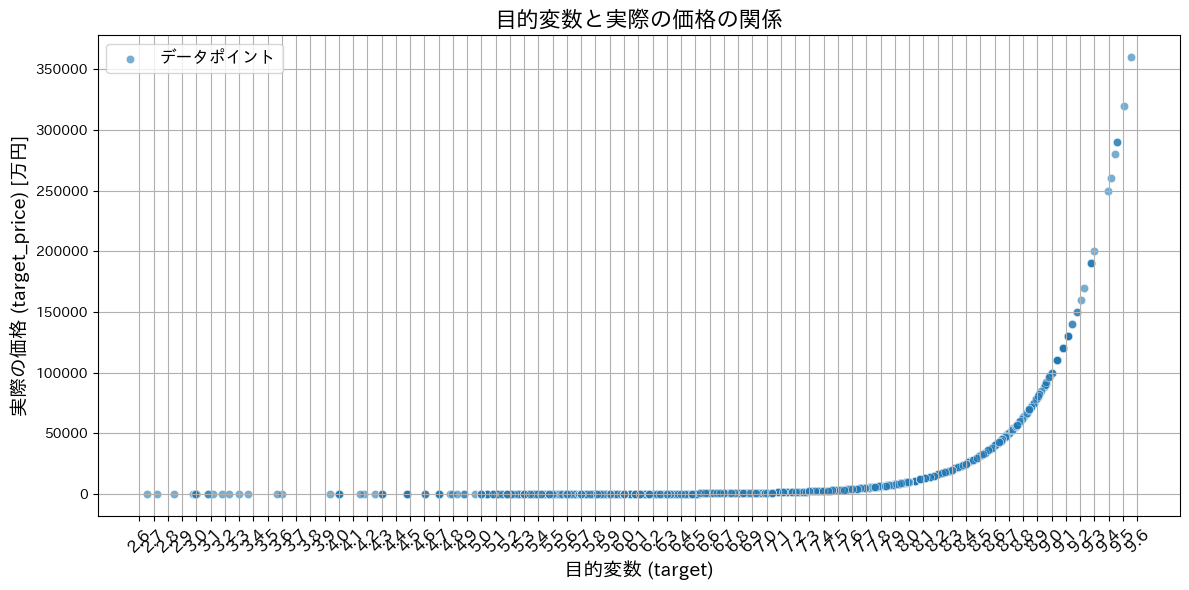

C:\Users\yuto2\AppData\Local\Temp\ipykernel_40508\1909287034.py:94: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


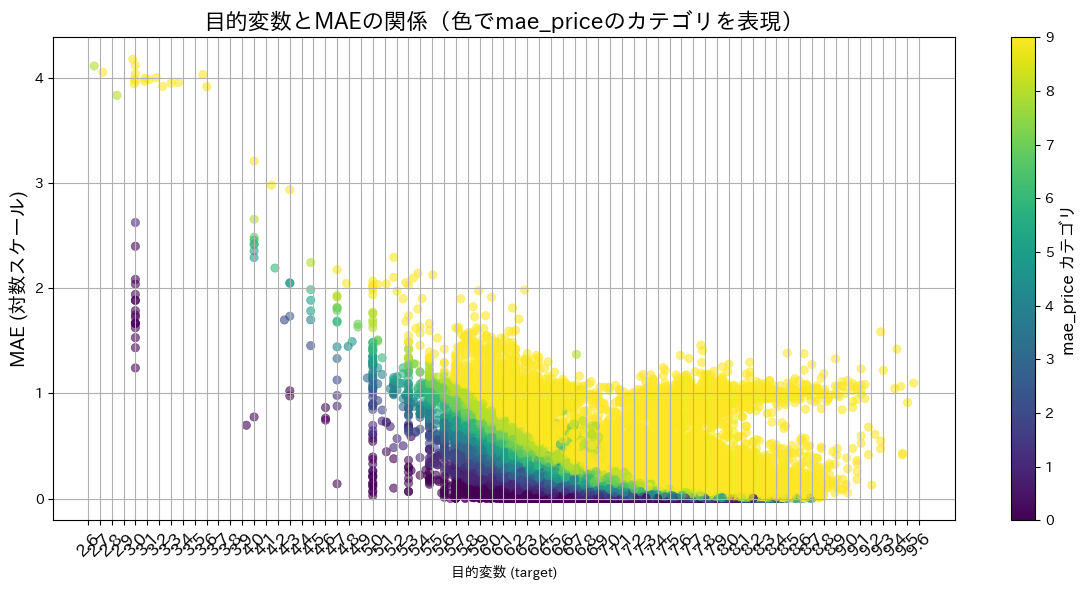

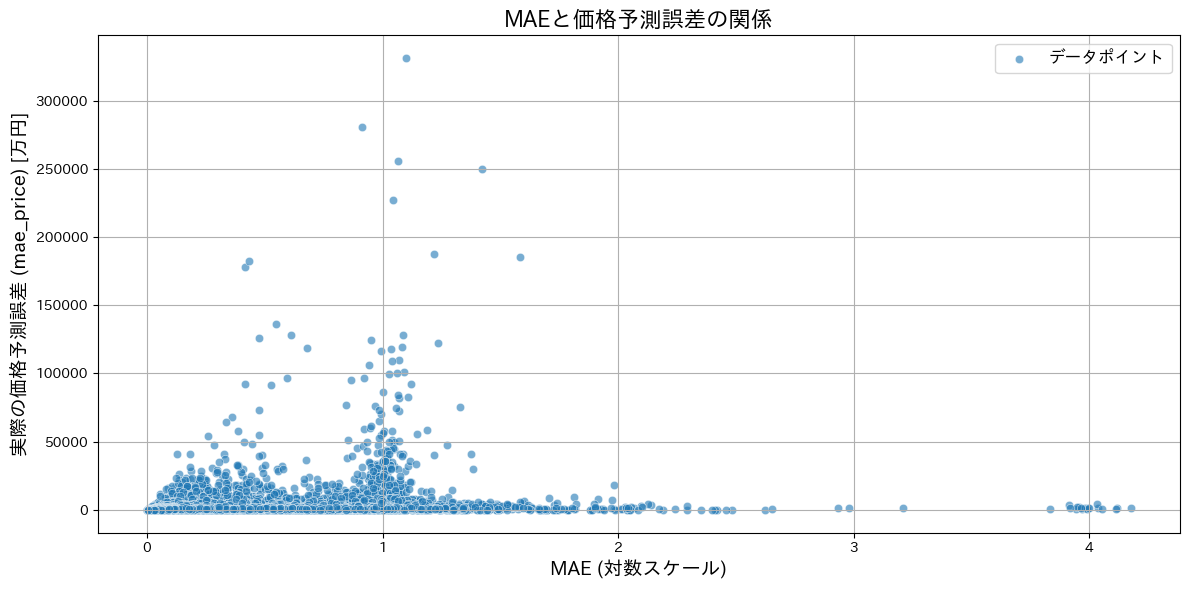

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.ticker as mticker

# target_priceの計算（targetがlog10(price)の場合）
train_preds_df["target_price"] = 10 ** train_preds_df["target"] / 10000

# 平均絶対誤差（MAE）の計算
train_preds_df["mae"] = abs(train_preds_df["target"] - train_preds_df["pred_weight"])

# target_priceが一定の値以上の行を削除する
threshold = 800000  # ここで削除したいtarget_priceの閾値を設定
if threshold is not None:
    train_preds_df = train_preds_df[train_preds_df["target_price"] < threshold]

# predicted_weight_priceの計算
train_preds_df["predicted_weight_price"] = 10 ** train_preds_df["pred_weight"] / 10000

# mae_priceの計算
train_preds_df["mae_price"] = abs(train_preds_df["target_price"] - train_preds_df["predicted_weight_price"])

# 上位10%の誤差が大きい物件を抽出
high_error_df = train_preds_df[train_preds_df['mae'] >= train_preds_df['mae'].quantile(0.9)]

# 下位10%の誤差が小さい物件を抽出
low_error_df = train_preds_df[train_preds_df['mae'] <= train_preds_df['mae'].quantile(0.1)]

# mae_priceのランキングを計算
train_preds_df['mae_price_rank'] = train_preds_df['mae_price'].rank(method='min', ascending=True)

# ランキングを正規化
scaler = MinMaxScaler()
train_preds_df['mae_price_rank_normalized'] = scaler.fit_transform(train_preds_df[['mae_price_rank']])

# 結果の表示
print("Filtered DataFrame:")
print(train_preds_df.head())

print("\nHigh Error DataFrame:")
print(high_error_df.head())

print("\nLow Error DataFrame:")
print(low_error_df.head())

# x軸のメモリを0.1刻みに設定するための範囲計算
min_target = train_preds_df['target'].min()
max_target = train_preds_df['target'].max()
x_ticks = np.arange(np.floor(min_target * 10) / 10, np.ceil(max_target * 10) / 10 + 0.1, 0.1)

# グラフのスタイル設定（オプション）
#sns.set(style="whitegrid")

# 1. 目的変数と実際の価格の関係を可視化
plt.figure(figsize=(12, 6))
sns.scatterplot(x='target', y='target_price', data=train_preds_df, alpha=0.6, label='データポイント')
# sns.regplot(x='target', y='target_price', data=train_preds_df, scatter=False, color='red', label='回帰線')

plt.title('目的変数と実際の価格の関係', fontsize=16)
plt.xlabel('目的変数 (target)', fontsize=14)
plt.ylabel('実際の価格 (target_price) [万円]', fontsize=14)
plt.xticks(x_ticks, rotation=45, fontsize=12)  # ラベルを45度回転し、フォントサイズを調整
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. 目的変数とMAEの関係を可視化（mae_priceのランキングに基づく色分け）
# mae_priceをカテゴリに分ける（例: quartiles）
train_preds_df['mae_price_category'] = pd.qcut(train_preds_df['mae_price'], q=10, labels=False)

plt.figure(figsize=(12, 6))
sns.scatterplot(
    x='target',
    y='mae',
    hue='mae_price_category',
    palette='viridis',
    data=train_preds_df,
    alpha=0.6,
    edgecolor=None
)

plt.title('目的変数とMAEの関係（色でmae_priceのカテゴリを表現）', fontsize=16)
plt.xlabel('目的変数 (target)', fontsize=10)
plt.ylabel('MAE (対数スケール)', fontsize=14)
plt.xticks(x_ticks, rotation=45, fontsize=12)

# カラーバーの追加
norm = plt.Normalize(train_preds_df['mae_price_category'].min(), train_preds_df['mae_price_category'].max())
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('mae_price カテゴリ', fontsize=12)



plt.legend([], [], frameon=False)  # 凡例を非表示にする（色のスケールのみ表示）
plt.grid(True)
plt.tight_layout()
plt.show()


# 3. MAEの値に対する実際の価格予測誤差 (mae_price) の関係を可視化
plt.figure(figsize=(12, 6))
sns.scatterplot(x='mae', y='mae_price', data=train_preds_df, alpha=0.6, label='データポイント')
# sns.regplot(x='mae', y='mae_price', data=train_preds_df, scatter=False, color='red', label='回帰線')

plt.title('MAEと価格予測誤差の関係', fontsize=16)
plt.xlabel('MAE (対数スケール)', fontsize=14)
plt.ylabel('実際の価格予測誤差 (mae_price) [万円]', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
print(abc)

Filtered DataFrame:
            価格情報区分 都道府県名   市区町村名    地区名  住所不一致_Flag              住所 最寄駅：名称  \
ID                                                                           
1046933  不動産取引価格情報   北海道  札幌市白石区    南郷通           0    北海道札幌市白石区南郷通  南郷７丁目   
1079053  不動産取引価格情報   北海道   札幌市西区  発寒１２条           0   北海道札幌市西区発寒１２条   発寒中央   
1170588     成約価格情報   北海道     江別市   大麻北町           0      北海道江別市大麻北町   森林公園   
1001637     成約価格情報   北海道  札幌市中央区   北５条西           0   北海道札幌市中央区北５条西  西２８丁目   
1014790  不動産取引価格情報   北海道  札幌市中央区  宮の森２条           0  北海道札幌市中央区宮の森２条  西２８丁目   

         最寄駅：距離（分）  徒歩時間_10分単位       x_api  ...  pred_weight  target_price  \
ID                                          ...                              
1046933        4.0         0.0  141.396484  ...     7.222208        1400.0   
1079053       11.0        10.0  141.297836  ...     7.102923        1400.0   
1170588        NaN         NaN  141.500595  ...     6.992784         590.0   
1001637        6.0         0.0  141.354538 

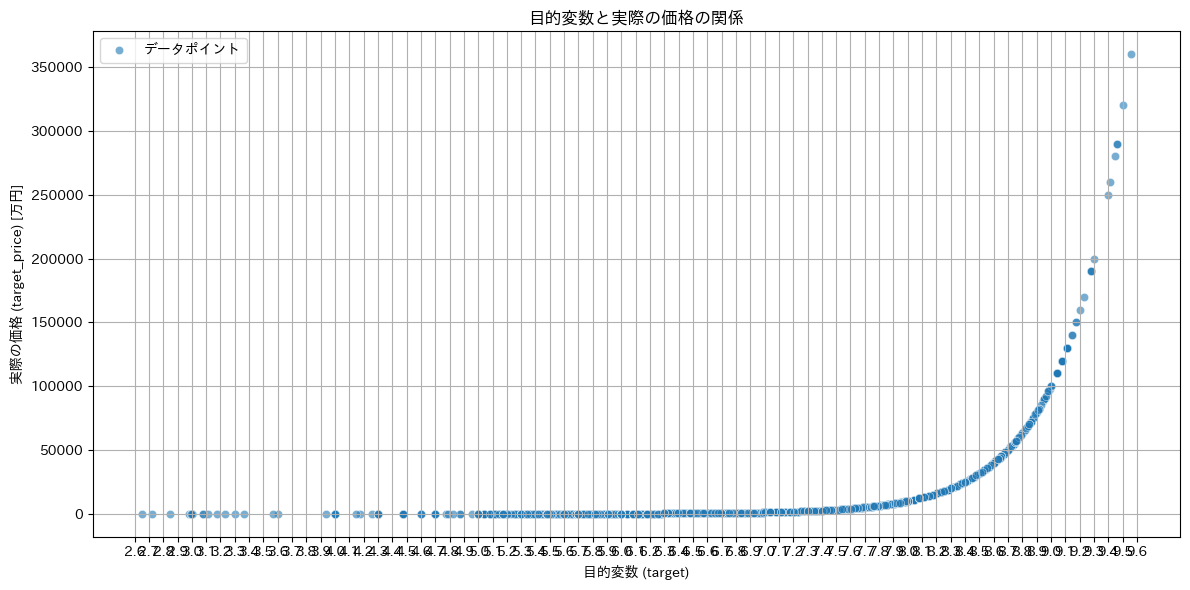

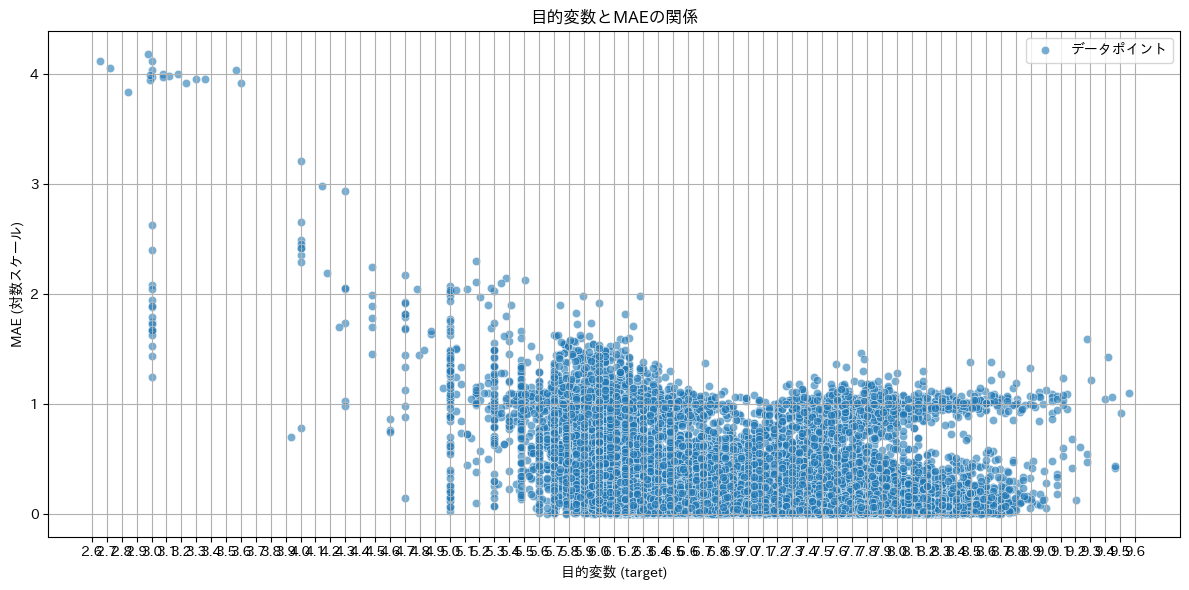

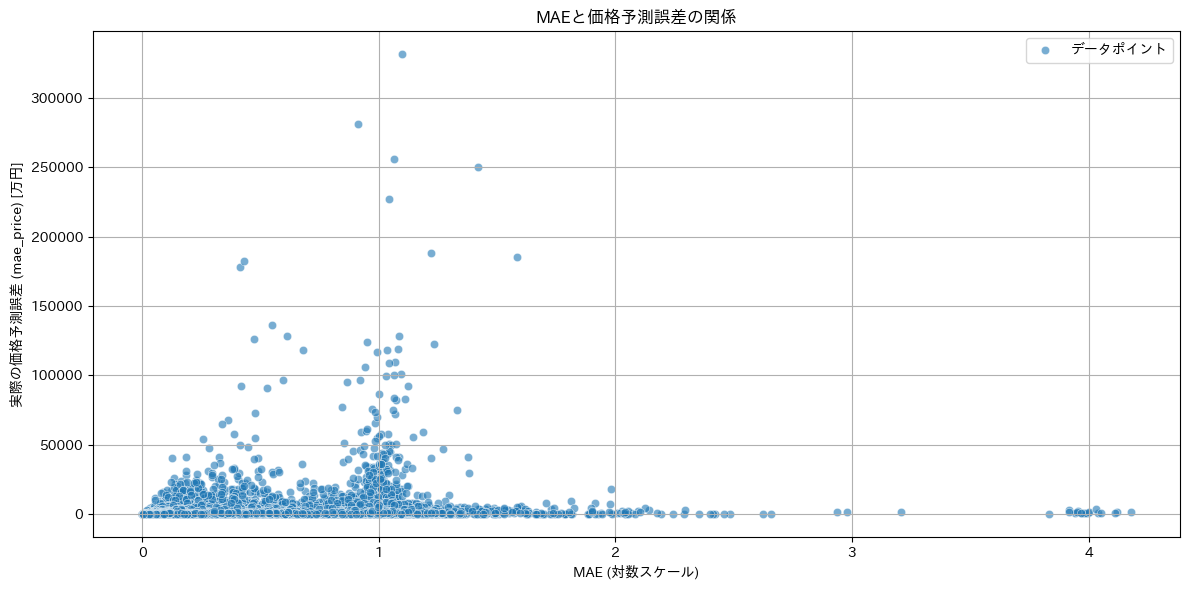

In [13]:
# target_priceの計算（targetがlog10(price)の場合）
train_preds_df["target_price"] = 10 ** train_preds_df["target"] / 10000

# 平均絶対誤差（MAE）の計算（対数スケール）
train_preds_df["mae"] = abs(train_preds_df["target"] - train_preds_df["pred_weight"])

# target_priceが一定の値以上の行を削除する
threshold = 800000  # ここで削除したいtarget_priceの閾値を設定
if threshold is not None:
    train_preds_df = train_preds_df[train_preds_df["target_price"] < threshold]

# predicted_weight_priceの計算（pred_weightがlog10(price)の場合）
train_preds_df["predicted_weight_price"] = 10 ** train_preds_df["pred_weight"] / 10000

# mae_priceの計算（価格スケールでの誤差）
train_preds_df["mae_price"] = abs(train_preds_df["target_price"] - train_preds_df["predicted_weight_price"])

# 上位10%の誤差が大きい物件を抽出
high_error_df = train_preds_df[train_preds_df['mae'] >= train_preds_df['mae'].quantile(0.9)]

# 下位10%の誤差が小さい物件を抽出
low_error_df = train_preds_df[train_preds_df['mae'] <= train_preds_df['mae'].quantile(0.1)]

# 結果の表示
print("Filtered DataFrame:")
print(train_preds_df.head())

print("\nHigh Error DataFrame:")
print(high_error_df.head())

print("\nLow Error DataFrame:")
print(low_error_df.head())

# x軸のメモリを0.1刻みに設定するための範囲計算
min_target = train_preds_df['target'].min()
max_target = train_preds_df['target'].max()
x_ticks = np.arange(np.floor(min_target * 10) / 10, np.ceil(max_target * 10) / 10 + 0.1, 0.1)

# グラフのスタイル設定（オプション）
#sns.set(style="whitegrid")

# 1. 目的変数と実際の価格の関係を可視化
plt.figure(figsize=(12, 6))
sns.scatterplot(x='target', y='target_price', data=train_preds_df, alpha=0.6, label='データポイント')
#sns.regplot(x='target', y='target_price', data=train_preds_df, scatter=False, color='red', label='回帰線')

plt.title('目的変数と実際の価格の関係')
plt.xlabel('目的変数 (target)')
plt.ylabel('実際の価格 (target_price) [万円]')
plt.xticks(x_ticks)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. 目的変数とMAEの関係を可視化
plt.figure(figsize=(12, 6))
sns.scatterplot(x='target', y='mae', data=train_preds_df, alpha=0.6, label='データポイント')
#sns.regplot(x='target', y='mae', data=train_preds_df, scatter=False, color='red', label='回帰線')

plt.title('目的変数とMAEの関係')
plt.xlabel('目的変数 (target)')
plt.ylabel('MAE (対数スケール)')
plt.xticks(x_ticks)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. MAEの値に対する実際の価格予測誤差 (mae_price) の関係を可視化
plt.figure(figsize=(12, 6))
sns.scatterplot(x='mae', y='mae_price', data=train_preds_df, alpha=0.6, label='データポイント')
#sns.regplot(x='mae', y='mae_price', data=train_preds_df, scatter=False, color='red', label='回帰線')

plt.title('MAEと価格予測誤差の関係')
plt.xlabel('MAE (対数スケール)')
plt.ylabel('実際の価格予測誤差 (mae_price) [万円]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
print(abc)

In [ ]:
# target_priceの計算
train_preds_df["target_price"] = 10 ** train_preds_df["target"] / 10000

# 平均絶対誤差（MAE）の計算（実際の価格予測誤差）
train_preds_df["mae"] = abs(train_preds_df["target"] - train_preds_df["pred_weight"])

# target_priceが一定の値以上の行を削除する
threshold = 50000  # ここで削除したいtarget_priceの閾値を設定
train_preds_df = train_preds_df[train_preds_df["target_price"] < threshold]

# predicted_weight_priceの計算
train_preds_df["predicted_weight_price"] = 10 ** train_preds_df["pred_weight"] / 10000

# mae_priceの計算（正しい方法）
train_preds_df["mae_price"] = abs(train_preds_df["target_price"] - train_preds_df["predicted_weight_price"])

# 上位10%の誤差が大きい物件を抽出
high_error_df = train_preds_df[train_preds_df['mae'] >= train_preds_df['mae'].quantile(0.9)]

# 下位10%の誤差が小さい物件を抽出
low_error_df = train_preds_df[train_preds_df['mae'] <= train_preds_df['mae'].quantile(0.1)]

# 結果の表示
print("Filtered DataFrame:")
print(train_preds_df.head())

print("\nHigh Error DataFrame:")
print(high_error_df.head())

print("\nLow Error DataFrame:")
print(low_error_df.head())

# x軸のメモリを0.1刻みに設定するための範囲計算
min_target = train_preds_df['target'].min()
max_target = train_preds_df['target'].max()
x_ticks = np.arange(np.floor(min_target * 10) / 10, np.ceil(max_target * 10) / 10 + 0.1, 0.1)

# グラフのスタイル設定（オプション）
#sns.set(style="whitegrid")

# 1. 目的変数と実際の価格の関係を可視化
plt.figure(figsize=(12, 6))
sns.scatterplot(x='target', y='target_price', data=train_preds_df, alpha=0.6, label='データポイント')
sns.regplot(x='target', y='target_price', data=train_preds_df, scatter=False, color='red', label='回帰線')

plt.title('目的変数と実際の価格の関係')
plt.xlabel('目的変数 (target)')
plt.ylabel('実際の価格 (target_price)')
plt.xticks(x_ticks)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. 目的変数とMAEの関係を可視化
plt.figure(figsize=(12, 6))
sns.scatterplot(x='target', y='mae', data=train_preds_df, alpha=0.6, label='データポイント')
sns.regplot(x='target', y='mae', data=train_preds_df, scatter=False, color='red', label='回帰線')

plt.title('目的変数とMAEの関係')
plt.xlabel('目的変数 (target)')
plt.ylabel('MAE')
plt.xticks(x_ticks)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. MAEの値に対する実際の価格予測誤差 (mae_price) の関係を可視化
plt.figure(figsize=(12, 6))
sns.scatterplot(x='mae', y='mae_price', data=train_preds_df, alpha=0.6, label='データポイント')
sns.regplot(x='mae', y='mae_price', data=train_preds_df, scatter=False, color='red', label='回帰線')

plt.title('MAEの値に対する実際の価格予測誤差の関係')
plt.xlabel('MAE')
plt.ylabel('実際の価格予測誤差 (mae_price)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
print(abc)

In [ ]:
# target_priceの計算
train_preds_df["target_price"]=10 ** train_preds_df["target"]
train_preds_df["target_price"]=train_preds_df["target_price"]/10000

# 平均絶対誤差（MAE）の計算
train_preds_df["mae"]=abs(train_preds_df["target"]-train_preds_df["pred_weight"])

# target_priceが一定の値以上の行を削除する
threshold = 10000  # ここで削除したいtarget_priceの閾値を設定
train_preds_df = train_preds_df[train_preds_df["target_price"] < threshold]

# predicted_priceの計算
train_preds_df["predicted_weight_price"] = 10 ** train_preds_df["pred_weight"] / 10000

# mae_priceの計算
train_preds_df["mae_price"] = abs(train_preds_df["target_price"] - train_preds_df["predicted_weight_price"])

# 上位10%の誤差が大きい物件
high_error_df = train_preds_df[train_preds_df['mae'] >= train_preds_df['mae'].quantile(0.9)]

# 下位10%の誤差が小さい物件
low_error_df = train_preds_df[train_preds_df['mae'] <= train_preds_df['mae'].quantile(0.1)]

# 必要に応じて結果を表示
print("Filtered DataFrame:")
print(train_preds_df.head())

print("\nHigh Error DataFrame:")
print(high_error_df.head())

print("\nLow Error DataFrame:")
print(low_error_df.head())

In [ ]:
# target_priceの計算
train_preds_df["target_price"]=10 ** train_preds_df["target"]
train_preds_df["target_price"]=train_preds_df["target_price"]/10000

# 平均絶対誤差（MAE）の計算
train_preds_df["mae"]=abs(train_preds_df["target"]-train_preds_df["pred_weight"])

# target_priceが一定の値以上の行を削除する
threshold = 10000  # ここで削除したいtarget_priceの閾値を設定
train_preds_df = train_preds_df[train_preds_df["target_price"] < threshold]

# predicted_priceの計算
train_preds_df["predicted_weight_price"] = 10 ** train_preds_df["pred_weight"] / 10000

# mae_priceの計算
train_preds_df["mae_price"] = abs(train_preds_df["target_price"] - train_preds_df["predicted_weight_price"])

# 上位10%の誤差が大きい物件
high_error_df = train_preds_df[train_preds_df['mae'] >= train_preds_df['mae'].quantile(0.9)]

# 下位10%の誤差が小さい物件
low_error_df = train_preds_df[train_preds_df['mae'] <= train_preds_df['mae'].quantile(0.1)]

# 必要に応じて結果を表示
print("Filtered DataFrame:")
print(train_preds_df.head())

print("\nHigh Error DataFrame:")
print(high_error_df.head())

print("\nLow Error DataFrame:")
print(low_error_df.head())

# x軸のメモリを0.1刻みに設定するための範囲計算
min_target = train_preds_df['target'].min()
max_target = train_preds_df['target'].max()
x_ticks = np.arange(np.floor(min_target * 10) / 10, np.ceil(max_target * 10) / 10 + 0.1, 0.1)

# グラフのスタイル設定（オプション）
#sns.set(style="whitegrid")

# 1. 目的変数と実際の価格の関係を可視化
plt.figure(figsize=(12, 6))
sns.scatterplot(x='target', y='target_price', data=train_preds_df, alpha=0.6, label='データポイント')
#sns.regplot(x='target', y='target_price', data=train_preds_df, scatter=False, color='red', label='回帰線')

plt.title('目的変数と実際の価格の関係')
plt.xlabel('目的変数 (target)')
plt.ylabel('実際の価格 (target_price)')
plt.xticks(x_ticks)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. 目的変数とMAEの関係を可視化
plt.figure(figsize=(12, 6))
sns.scatterplot(x='target', y='mae', data=train_preds_df, alpha=0.6, label='データポイント')
#sns.regplot(x='target', y='mae', data=train_preds_df, scatter=False, color='red', label='回帰線')

plt.title('目的変数とMAEの関係')
plt.xlabel('目的変数 (target)')
plt.ylabel('MAE')
plt.xticks(x_ticks)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. 目的変数と実際の価格予測誤差 (actual_error) の関係を可視化
plt.figure(figsize=(12, 6))
sns.scatterplot(x='mae', y='mae_price', data=train_preds_df, alpha=0.6, label='データポイント')
#sns.regplot(x='mae', y='mae_price', data=train_preds_df, scatter=False, color='red', label='回帰線')

plt.title('目的変数と実際の価格予測誤差の関係')
plt.xlabel('目的変数 (target)')
plt.ylabel('実際の価格予測誤差 (actual_error)')
plt.xticks(x_ticks)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# x軸のメモリを0.1刻みに設定するための範囲計算
min_target = train_preds_df['target'].min()
max_target = train_preds_df['target'].max()
x_ticks = np.arange(np.floor(min_target * 10) / 10, np.ceil(max_target * 10) / 10 + 0.1, 0.1)

#1. 実際の価格を目的変数に基づいて可視化
plt.figure(figsize=(12, 6))
sns.scatterplot(x='target', y='target_price', data=train_preds_df, alpha=0.6, label='データポイント')

# 回帰線を追加（オプション）
sns.regplot(x='target', y='target_price', data=train_preds_df, scatter=False, color='red', label='回帰線')

plt.title('目的変数と実際の価格の関係')
plt.xlabel('目的変数 (target)')
plt.ylabel('実際の価格 (target_price)')

# x軸のメモリを0.1刻みに設定
min_target = train_preds_df['target'].min()
max_target = train_preds_df['target'].max()
# 小数点以下1桁で範囲を設定
plt.xticks(np.arange(np.floor(min_target * 10) / 10, np.ceil(max_target * 10) / 10 + 0.1, 0.1))

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



#2. MAEを目的変数に基づいて可視化
plt.figure(figsize=(12, 6))
sns.scatterplot(x='target', y='mae', data=train_preds_df, alpha=0.6, label='データポイント')

# 回帰線を追加（オプション）
sns.regplot(x='target', y='mae', data=train_preds_df, scatter=False, color='red', label='回帰線')

plt.title('目的変数とMAEの関係')
plt.xlabel('目的変数 (target)')
plt.ylabel('MAE')

# x軸のメモリを0.1刻みに設定（前のグラフと同じ範囲を使用）
plt.xticks(np.arange(np.floor(min_target * 10) / 10, np.ceil(max_target * 10) / 10 + 0.1, 0.1))

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# 3. 目的変数と実際の価格予測誤差 (actual_error) の関係を可視化
plt.figure(figsize=(12, 6))
sns.scatterplot(x='target', y='actual_error', data=train_preds_df, alpha=0.6, label='データポイント')
sns.regplot(x='target', y='actual_error', data=train_preds_df, scatter=False, color='red', label='回帰線')

plt.title('目的変数と実際の価格予測誤差の関係')
plt.xlabel('目的変数 (target)')
plt.ylabel('実際の価格予測誤差 (actual_error)')
plt.xticks(x_ticks)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# 実際の価格を目的変数に基づいて可視化
plt.figure(figsize=(10, 6))
sns.scatterplot(x='target', y='target_price', data=train_preds_df, alpha=0.6, label='データポイント')

# 回帰線を追加（オプション）
sns.regplot(x='target', y='target_price', data=train_preds_df, scatter=False, color='red', label='回帰線')

plt.title('目的変数と実際の価格の関係')
plt.xlabel('目的変数 (target)')
plt.ylabel('実際の価格 (target_price)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np

def extended_describe(df):
    """
    DataFrame の基本情報に加えて欠損率などを出力する。
    """
    # 各カラムの基本統計量
    desc = df.describe(include='all').T
    
    # カラムのデータ型
    desc['dtype'] = df.dtypes
    
    # 欠損数と欠損率
    missing_count = df.isnull().sum()
    missing_rate = df.isnull().mean() * 100
    
    desc['missing_count'] = missing_count
    desc['missing_rate(%)'] = missing_rate
    
    return desc

# 使い方
extended_df = extended_describe(train_preds_df)
print(extended_df)


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
train_preds_df['mae'].hist(bins=50, alpha=0.7, color='steelblue')
plt.xlabel('MAE')
plt.ylabel('Frequency')
plt.title('Distribution of MAE')
plt.show()


In [ ]:
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.kdeplot(train_preds_df['mae'], shade=True, color='steelblue')
plt.xlabel('MAE')
plt.ylabel('Density')
plt.title('KDE of MAE')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 6))
sns.scatterplot(
    x=train_preds_df['target'], 
    y=train_preds_df['pred_weight'],
    alpha=0.3
)
plt.plot([train_preds_df['target'].min(), train_preds_df['target'].max()],
         [train_preds_df['target'].min(), train_preds_df['target'].max()],
         color='red', linestyle='--')
plt.xlabel('Actual (target)')
plt.ylabel('Prediction (pred_weight)')
plt.title('Target vs. Prediction Scatter Plot')
plt.show()


In [ ]:
data_for_box = [
    train_preds_df['mae'],
    high_error_df['mae'],
    low_error_df['mae']
]

plt.figure(figsize=(7, 5))
plt.boxplot(data_for_box, labels=['All', 'High Error', 'Low Error'])
plt.title('Box Plot of MAE')
plt.ylabel('MAE')
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 相関を見たいカラムを選択
cols_for_corr = [
    'target', 
    'pred_weight', 
    'mae', 
    '面積（㎡）', 
    '最寄駅：距離（分）', 
    '購入までの築年数',
    # 必要に応じて追加
]

corr_df = train_preds_df.corr()
plt.figure(figsize=(32, 20))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()


In [ ]:
price_bins = pd.cut(train_preds_df['target_price'], bins=20)
age_bins = pd.cut(train_preds_df['購入までの築年数'], bins=20)

heatmap_data = train_preds_df.groupby([price_bins, age_bins])['mae'].mean().unstack()

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu")
plt.xlabel('Building Age Bins')
plt.ylabel('Transaction Price Bins')
plt.title('MAE Heatmap by Price and Building Age')
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.histplot(
    data=train_preds_df, 
    x='target_price', 
    y='mae', 
    bins=50,        # bin数はデータ量や可読性に合わせて調整
    pthresh=0.05,   # これ以下の頻度は閾値として見えにくくなる
    cmap='mako',    # カラーマップ
)
plt.title('2D Histogram of target_price vs. MAE')
plt.xlabel('target_price (万円)')
plt.ylabel('MAE (log単価差)')
plt.show()


In [ ]:
plt.figure(figsize=(8, 6))
plt.hexbin(
    x=train_preds_df['target_price'], 
    y=train_preds_df['mae'], 
    gridsize=50, 
    cmap='viridis'
)
cb = plt.colorbar()
cb.set_label('count in bin')
plt.xlabel('target_price (万円)')
plt.ylabel('MAE (log単価差)')
plt.title('Hexbin Plot of target_price vs. MAE')
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 例: target_price を等間隔で 10 個にビニング
train_preds_df['price_bin'] = pd.cut(
    train_preds_df['target_price'], 
    bins=10, 
    labels=[f'bin{i}' for i in range(1, 11)]
)

plt.figure(figsize=(12, 6))
sns.boxplot(data=train_preds_df, x='price_bin', y='mae')
plt.xlabel('target_price bins')
plt.ylabel('MAE')
plt.title('MAE Distribution by Price Bins (Boxplot)')
plt.show()


In [ ]:
import numpy as np

# 例えば 100,000 レコードをサンプリング
sample_n = 100_000
if len(train_preds_df) > sample_n:
    plot_df = train_preds_df.sample(n=sample_n, random_state=42)
else:
    plot_df = train_preds_df

plt.figure(figsize=(8, 6))
plt.scatter(
    plot_df['target_price'], 
    plot_df['mae'], 
    alpha=0.3
)
plt.xlabel('target_price (万円)')
plt.ylabel('MAE (log単価差)')
plt.title('Scatter Plot of Price vs. MAE (Sampled)')
plt.show()


In [ ]:
print(abc)

In [7]:
train_preds_df["target_price"]=10 ** train_preds_df["target"]
train_preds_df["target_price"]=train_preds_df["target_price"]/10000

In [8]:
train_preds_df["mae"]=abs(train_preds_df["target"]-train_preds_df["pred_weight"])

# 上位10%の誤差が大きい物件
high_error_df = train_preds_df[train_preds_df['mae'] >= train_preds_df['mae'].quantile(0.9)]

# 下位10%の誤差が小さい物件
low_error_df = train_preds_df[train_preds_df['mae'] <= train_preds_df['mae'].quantile(0.1)]


In [ ]:
check_dataframe_elements(train_preds_df)

In [ ]:
# 誤差が小さい物件の統計
#print(low_error_df.describe())
low_error_describe_df=low_error_df.describe()
#plot1=pd.plotting.scatter_matrix(low_error_df[cols],figsize=(20,20))
#plt.show()

#誤差が小さい物件のMAE
low_error_mae=mean_absolute_error(low_error_df["target"],low_error_df["pred_weight"])
print("MAE low10%",low_error_mae)
#------------------------------------------------------------------------------------

# 誤差が大きい物件の統計
#print(high_error_df.describe())
high_error_describe_df=high_error_df.describe()
#plot2=pd.plotting.scatter_matrix(high_error_df[cols],figsize=(20,20))
#plt.show()

#誤差が大きい物件のMAE
high_error_mae=mean_absolute_error(high_error_df["target"],high_error_df["pred_weight"])
print("MAE high10%",high_error_mae)

In [ ]:
mae=0.063858
price_log=7.602059991327962
#price_per_area = 10 ** 0.065
#print(price_per_area)

#price_per_area_lower = 10 ** (7.60205999-mae)
#print("予測値下限")
#print(price_per_area_lower)

mae=0.063858
price_per_area = 10 ** price_log
print("取引価格")
print(price_per_area)

# 対数スケールの誤差範囲をもとにした実際の価格の誤差範囲
price_min = price_per_area * (10 ** -mae)
price_max = price_per_area * (10 ** mae)

print("誤差範囲（最小）:", price_min)
print("誤差範囲（最大）:", price_max)
print("±：", price_max-price_per_area)
#price_per_area_upper = 10 ** (7.60205999+mae)
#print("予測値上限")
#print(price_per_area_upper)

#diff=price_per_area_upper-price_per_area_lower
#print(diff)

#print(f"誤差{price_per_area_lower-price_per_area}~{price_per_area_upper-price_per_area}")

In [ ]:
import matplotlib.pyplot as plt

plot_feature="target_price"

# 例: 築年数と誤差の関係を可視化
plt.figure(figsize=(10, 5))
plt.scatter(train_preds_df[plot_feature], train_preds_df['mae'], alpha=0.5)
plt.xlabel(f'{plot_feature}')
plt.ylabel('MAE')
plt.title('Building Age vs MAE')
plt.show()

# 例: 築年数と誤差の関係を可視化
plt.figure(figsize=(10, 5))
plt.scatter(low_error_df[plot_feature], low_error_df['mae'], alpha=0.5)
plt.xlabel(f'{plot_feature}')
plt.ylabel('MAE')
plt.title('Building Age vs MAE')
plt.show()

# 例: 築年数と誤差の関係を可視化
plt.figure(figsize=(10, 5))
plt.scatter(high_error_df[plot_feature], high_error_df['mae'], alpha=0.5)
plt.xlabel(f'{plot_feature}')
plt.ylabel('MAE')
plt.title('Building Age vs MAE')
plt.show()


In [ ]:
#ヒートマップ

price_bins = pd.cut(train_preds_df['target_price'], bins=20)
age_bins = pd.cut(train_preds_df['購入までの築年数'], bins=20)

heatmap_data = train_preds_df.groupby([price_bins, age_bins])['mae'].mean().unstack()

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu")
plt.xlabel('Building Age Bins')
plt.ylabel('Transaction Price Bins')
plt.title('MAE Heatmap by Price and Building Age')
plt.show()


In [ ]:
# 例: エリアごとの平均MAE
area_mae = train_preds_df.groupby('都道府県名')['mae'].mean().sort_values()
print(area_mae)
